In [1]:
import os

import numpy as np

import matplotlib.pyplot as plt
from matplotlib.image import imread
from matplotlib.animation import FuncAnimation

import scipy as sp
from scipy.ndimage import zoom
from scipy.optimize import linprog
from scipy.fftpack import dct, idct
from scipy.linalg import qr

from sklearn.preprocessing import normalize

import imageio
import io

# Exercise 3-1
Load the image dog.jpg and convert to grayscale. We will repeat Exercise 2-1, using the FFT to compress the image at different compression ratios. However, now, we will compare the error versus compression ratio for the image downsampled at different resolutions. Compare the original image (2000×1500) and downsampled copies of the following resolutions: 1000×750, 500 × 375, 200 × 150, and 100 × 75. Plot the error versus compression ratio for each image resolution on the same plot. Explain the observed trends.

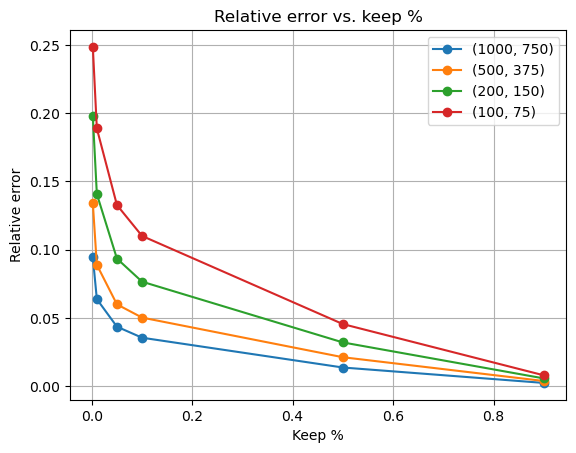

In [2]:
A = imread(os.path.join('..','DATA','dog.jpg'))
B = np.mean(A, -1); # Convert RGB to grayscale

resolutions = [(1000, 750), (500, 375), (200, 150), (100, 75)]
errors = []

keep = [0.9, 0.5, 0.1, 0.05, 0.01, 0.002]

for j in resolutions:

    downscaled_image = B[::A.shape[0]//j[0], ::A.shape[1]//j[1]]

    Bt = np.fft.fft2(downscaled_image)
    Btsort = np.sort(np.abs(Bt.reshape(-1))) # sort by magnitude

    temp = []

    for i in keep:
        thresh = Btsort[int(np.floor((1-i)*len(Btsort)))]
        ind = np.abs(Bt)>thresh          # Find small indices
        Atlow = Bt * ind                 # Threshold small indices
        Alow = np.fft.ifft2(Atlow).real  # Compressed image
        temp.append(np.linalg.norm(downscaled_image-Alow)/np.linalg.norm(downscaled_image))
    
    else:
        errors.append(temp)


for i, val in enumerate(errors):
    plt.plot(keep, val, 'o-', label = str(resolutions[i]))

plt.xlabel('Keep %')
plt.ylabel('Relative error')
plt.title('Relative error vs. keep %')
plt.legend()
plt.grid()
plt.show()

The relative error is large for a low amount of information keep which is to be expected. The lower resolution have more error here aswell and that is probably because there is simply less information to keep. But the error kind of converge for higher % keep. This might be explain that there is a lower "manifold" where the picture lives and hence ones you have enogh information to describe that "manifold" the resolution does not matter as much. 

# Exercise 3-2

This example will explore geometry and sampling probabilities in high-dimensional spaces. Consider a two-dimensional square dart board with length $L = 2$ on both sides and a circle of radius $R = 1$ in the middle. Write a program to throw 10 000 darts by generating a uniform random $x$ and $y$ position on the square. Compute the radius for each point and compute what fraction
land inside the circle (i.e., how many have radius $\geq 1$). Is this consistent with your expectation based on the area of the circle and the square? Repeat this experiment, throwing 10 000 darts randomly (sampled from a uniform distribution) on an N-dimensional cube (length $L = 2$) with an N-dimensional sphere inside (radius $R = 1$), for $N = 2$ through $N = 10$. For a given N, what fraction of the points land inside the sphere. Plot this fraction versus N. Also compute the histogram of the radii of the randomly sampled points for each N and plot these. What trends do you notice in the data?

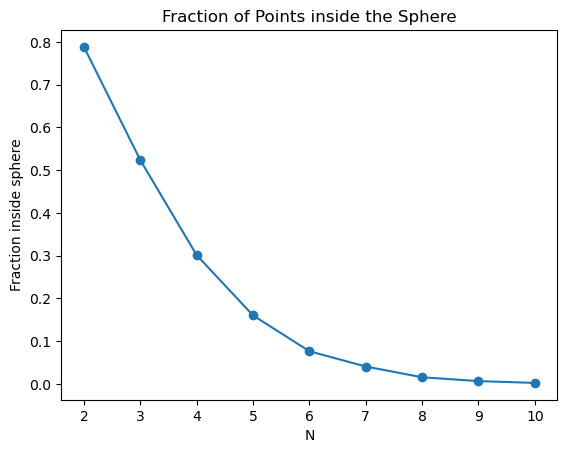

KeyboardInterrupt: 

In [3]:
def throw_darts(n_darts, n_dimensions):
    radii = []
    inside_sphere = 0

    for _ in range(n_darts):
        point = np.random.uniform(-1, 1, size=n_dimensions)
        radius = np.linalg.norm(point)
        radii.append(radius)

        if radius <= 1:
            inside_sphere += 1

    fraction_inside = inside_sphere / n_darts
    return radii, fraction_inside

N_values = range(2, 11)
fraction_inside_values = []
radii_histograms = []

for N in N_values:
    radii, fraction_inside = throw_darts(10000, N)
    fraction_inside_values.append(fraction_inside)
    radii_histograms.append(radii)

# Plot fraction inside sphere versus N
plt.figure()
plt.plot(N_values, fraction_inside_values, marker='o')
plt.xlabel('N')
plt.ylabel('Fraction inside sphere')
plt.title('Fraction of Points inside the Sphere')
plt.show()

# Plot histograms of radii for each N
plt.figure(figsize=(12, 6))
for i, radii in enumerate(radii_histograms):
    plt.subplot(2, 5, i + 1)
    plt.hist(radii, bins=30)
    plt.xlabel('Radius')
    plt.ylabel('Frequency')
    plt.title(f'N = {N_values[i]}')

plt.tight_layout()
plt.show()


The trend we see here is that the fraction of points that land inside the sphere decreases as the dimensionality increases. This is because the volume of the sphere decreases as the dimensionality increases. The histogram of the radii of the randomly sampled points for each N is also interesting. We see that the distribution of the radii becomes more and more concentrated around the radius of the sphere as the dimensionality increases. This is because the volume of the sphere becomes a smaller and smaller fraction of the volume of the cube as the dimensionality increases.

# Exercise 3-3 
This exercise will explore the relationship between the sparsity K, the signal size n, and the number of samples p in compressed sensing.

(a) For $n = 1000$ and $K=5$ create a K-sparse vector s of Fourier coefficients in a Fourier basis $\Psi$. For each p from 1 to 100, create a Gaussian random
sampling matrix $C\in \mathcal{R}^{p\times n}$ to create a measurement vector $y = C\Phi s$. Use compressed sensing based on this measurement to estimate $\hat{s}$. For each p, repeat this with at least 10 realizations of the random measurement matrix C. Plot the average relative error of $\|\hat{s} - s\|_2/\|s\|_2$ versus p; it may be helpful to visualize the errors with a box-and-whisker plot. Explain the trends. Also plot the average $\ell_1$ and $\ell_0$ error versus p.

(b) Repeat part (a) for $K = 1$ through $K = 50$. What changes?

(c) Now repeat the above experiment for $K = 5$, varying the signal size using $n = 100$, $n = 500$, $n = 1000$, $n = 2000$, and $n = 5000$.

In [2]:
def create_K_sparse_vector(n, K):
    s = np.zeros(n)
    indices = np.random.choice(n, K, replace=False)
    values = np.random.normal(0, 1, K)
    s[indices] = values
    return s

In [3]:
def get_optimal_x_for_bp(A, y): # https://stackoverflow.com/questions/56424993/is-there-a-python-implementation-of-a-basis-pursuit-solver
    x_dim, y_dim = A.shape[1], y.shape[0]
    eye = np.eye(x_dim)

    obj = np.concatenate([np.zeros(x_dim), np.ones(x_dim)])

    lhs_ineq = np.concatenate([np.concatenate([eye, -eye], axis=1), np.concatenate([-eye, -eye], axis=1)], axis=0)
    rhs_ineq = np.zeros(2 * x_dim)

    lhs_eq = np.concatenate([A, np.zeros((y_dim, x_dim))], axis=1)
    rhs_eq = y

    bnd = [*((None, None) for _ in range(x_dim)), *((0, None) for _ in range(x_dim))]

    res = linprog(c=obj, A_ub=lhs_ineq, b_ub=rhs_ineq, A_eq=lhs_eq, b_eq=rhs_eq, bounds=bnd)
    return res.x[:x_dim]

In [32]:
def experiment(n, K , random_process, binomial = False):
    relative_error = []
    l0_norm = []
    l1_norm = []

    for p in range(1, 101):
        if p % 10 == 0:
            print(p, '/', 100)
        s = create_K_sparse_vector(n, K)
        Psi = dct(np.identity(n))
        temp_rel = []
        temp_0 = []
        temp_1 = []
        for _ in range(10):
            if binomial == True:
                C = random_process(1,0.5,size=(p, n))
            else:
                C = random_process(size=(p, n))
            y = C @ Psi @ s
            s_hat = get_optimal_x_for_bp(C @ Psi, y)
            temp_rel.append(np.linalg.norm(s_hat-s)/np.linalg.norm(s))
            temp_0.append(np.linalg.norm(s-s_hat, ord = 0))
            temp_1.append(np.linalg.norm(s-s_hat, ord = 1))

        relative_error.append(temp_rel)
        l0_norm.append(temp_0)
        l1_norm.append(temp_1)
    return relative_error, l0_norm, l1_norm

In [18]:
def error_plot(lst1, lst2, lst3):
    plt.figure(figsize=(30, 5))
    plt.boxplot(lst1)
    plt.xlabel('Number of Measurements p')
    plt.ylabel('Relative L2 Error')
    plt.title('Box-and-Whisker Plot of Relative Errors')
    plt.show()

    plt.figure(figsize=(30, 5))
    averages = [np.mean(arr) for arr in lst2]
    plt.plot(averages, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Measurements p')
    plt.ylabel('Average Error')
    plt.title('L0 Error')
    plt.show()

    plt.figure(figsize=(30, 5))
    averages = [np.mean(arr) for arr in lst3]
    plt.plot(averages, marker='o', linestyle='-', color='b')
    plt.xlabel('Number of Measurements p')
    plt.ylabel('Average Error')
    plt.title('L1 Error')
    plt.show()

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


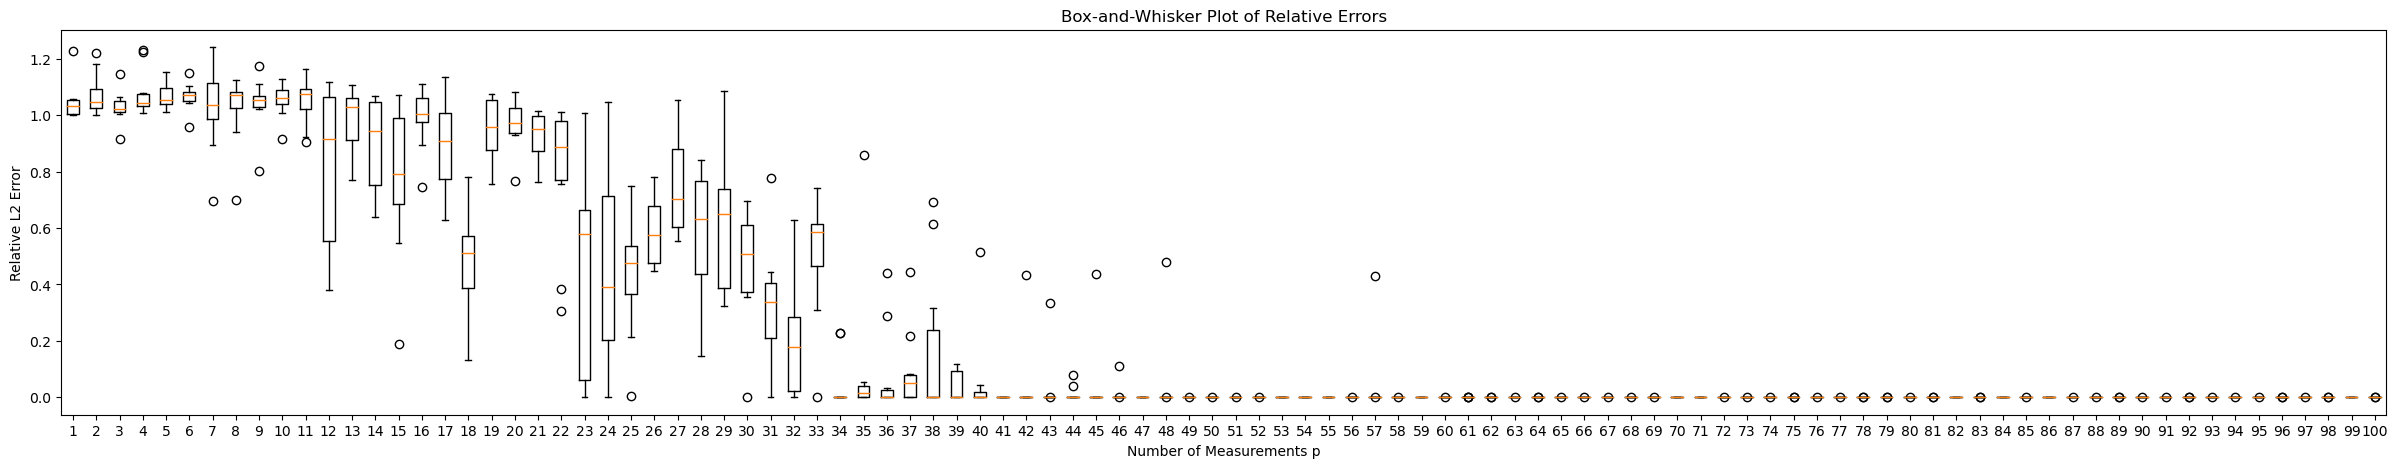

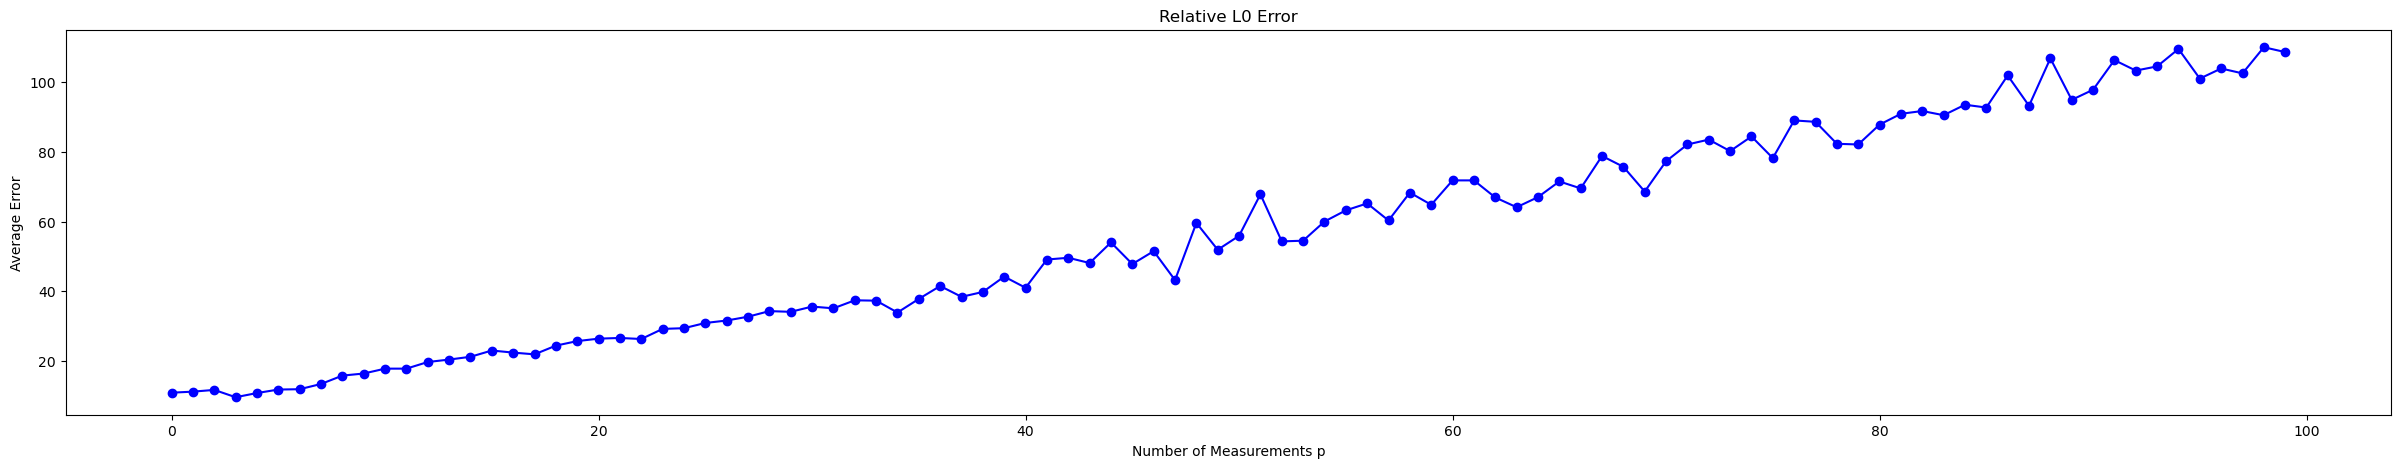

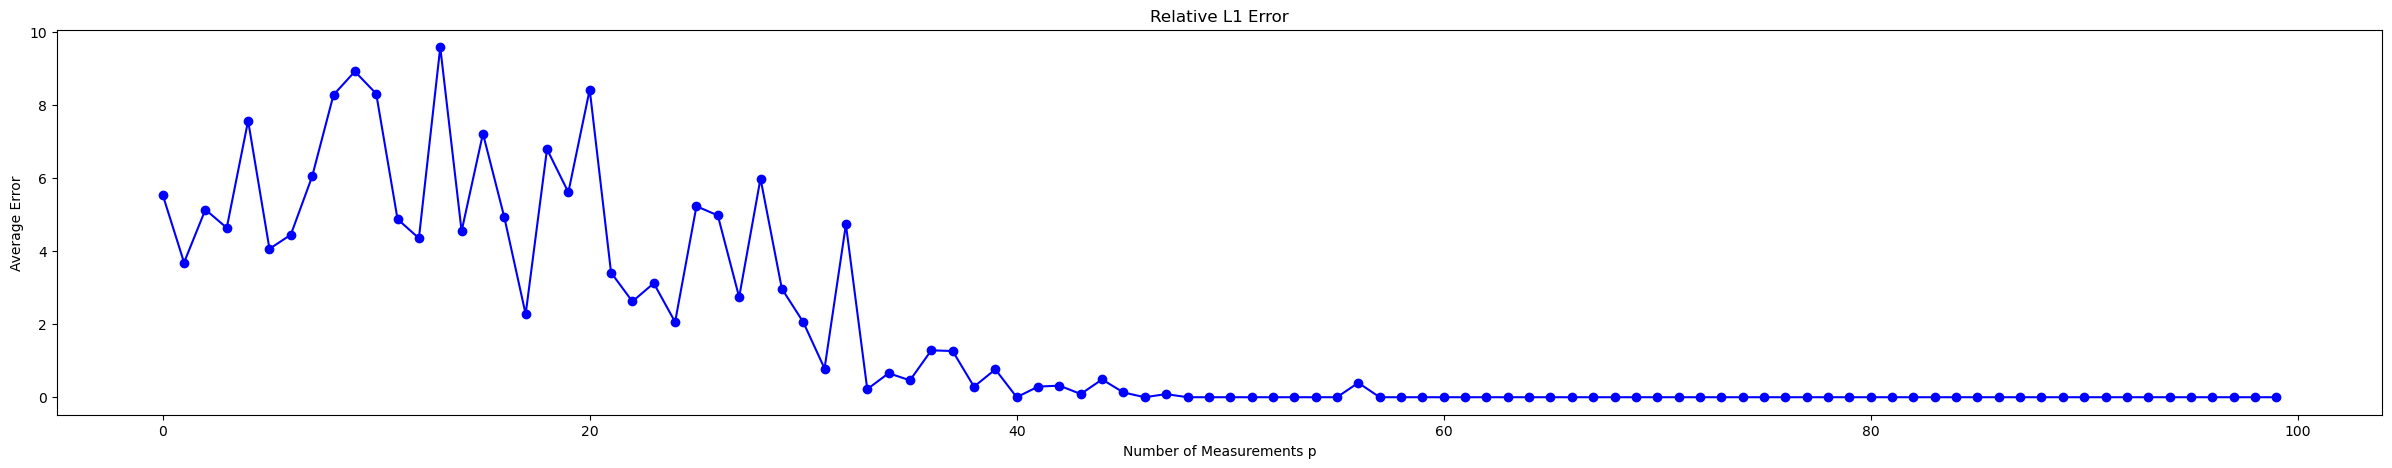

In [19]:
n = 1000
K = 5

random_process = np.random.normal

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

Until we get a sufficently large p the error is all over the place. But around 43 we basically get no error.

The l0 norm increases as we increase p. This is because the l0 norm is the number of non-zero elements in the vector. As we increase p, we get more measurements and hence more non-zero elements in the vector. The l1 norm decreases as we increase p. This is expected as we find s using the l1 norm optimization.

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


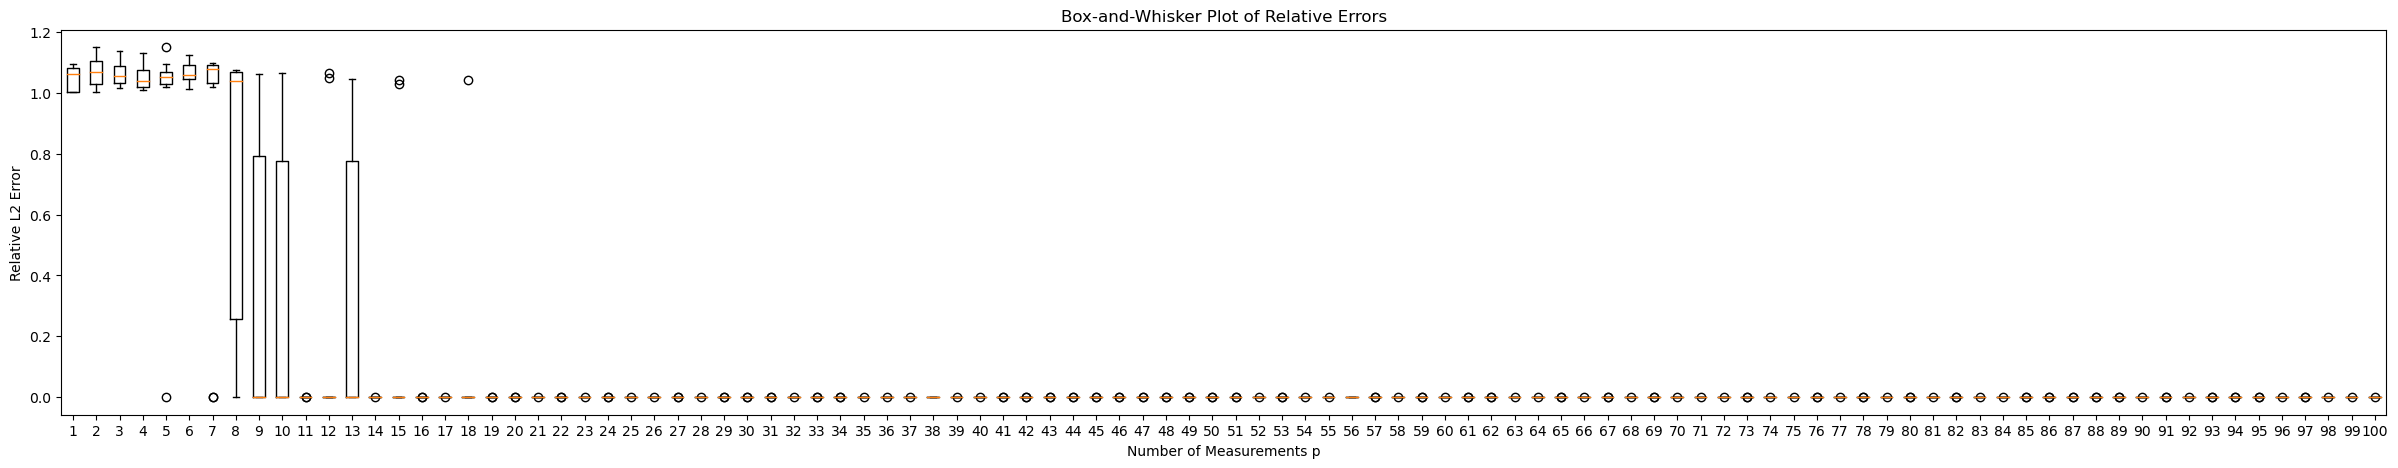

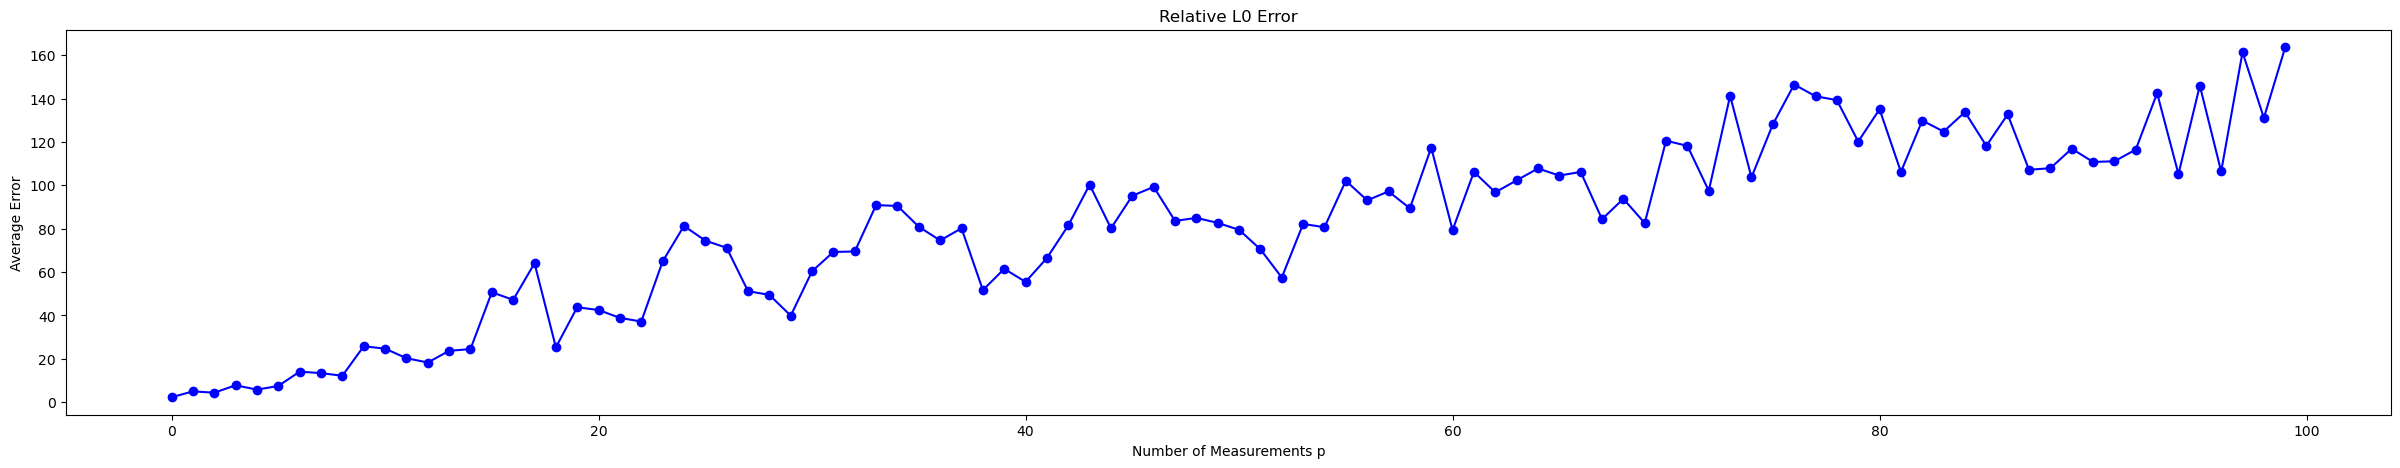

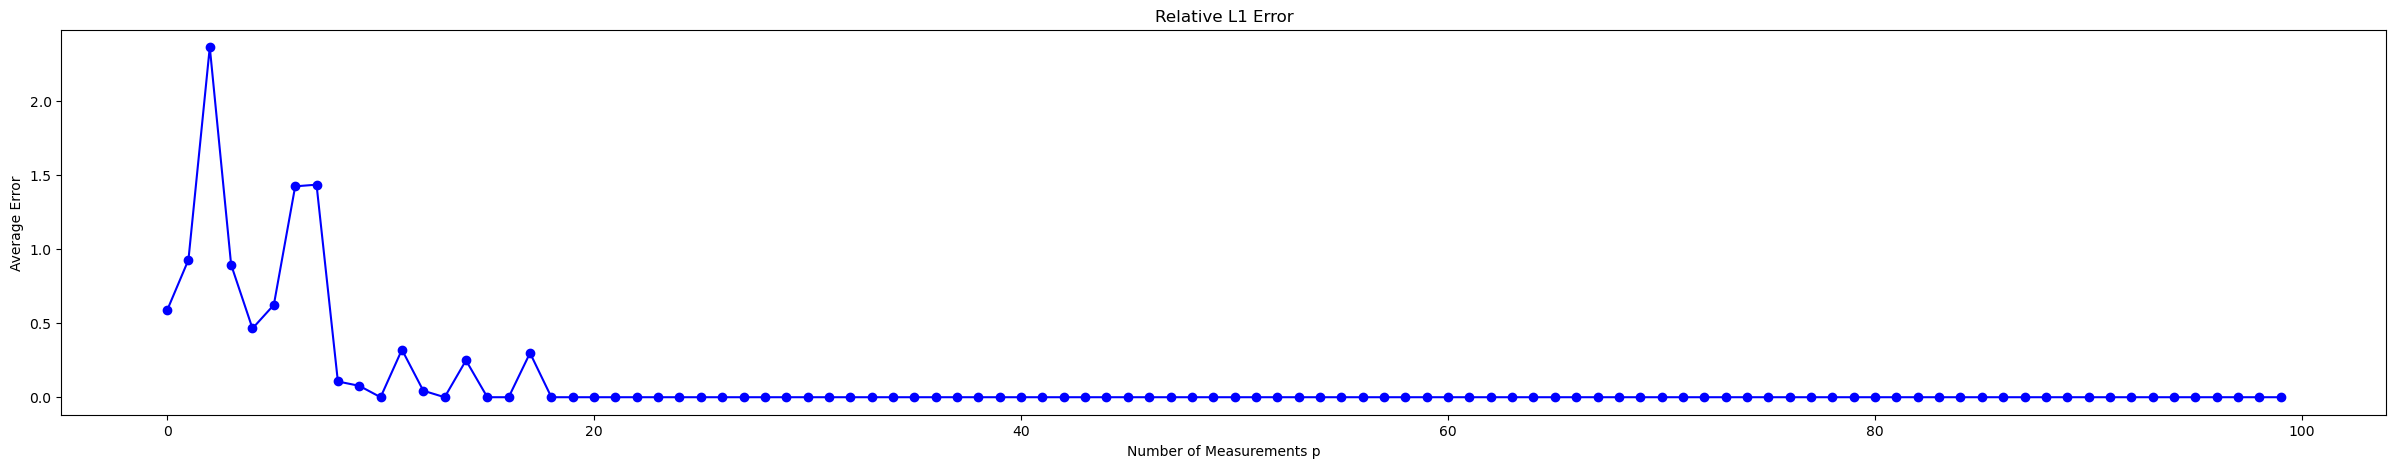

In [20]:
n = 1000
K = 1

random_process = np.random.normal

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


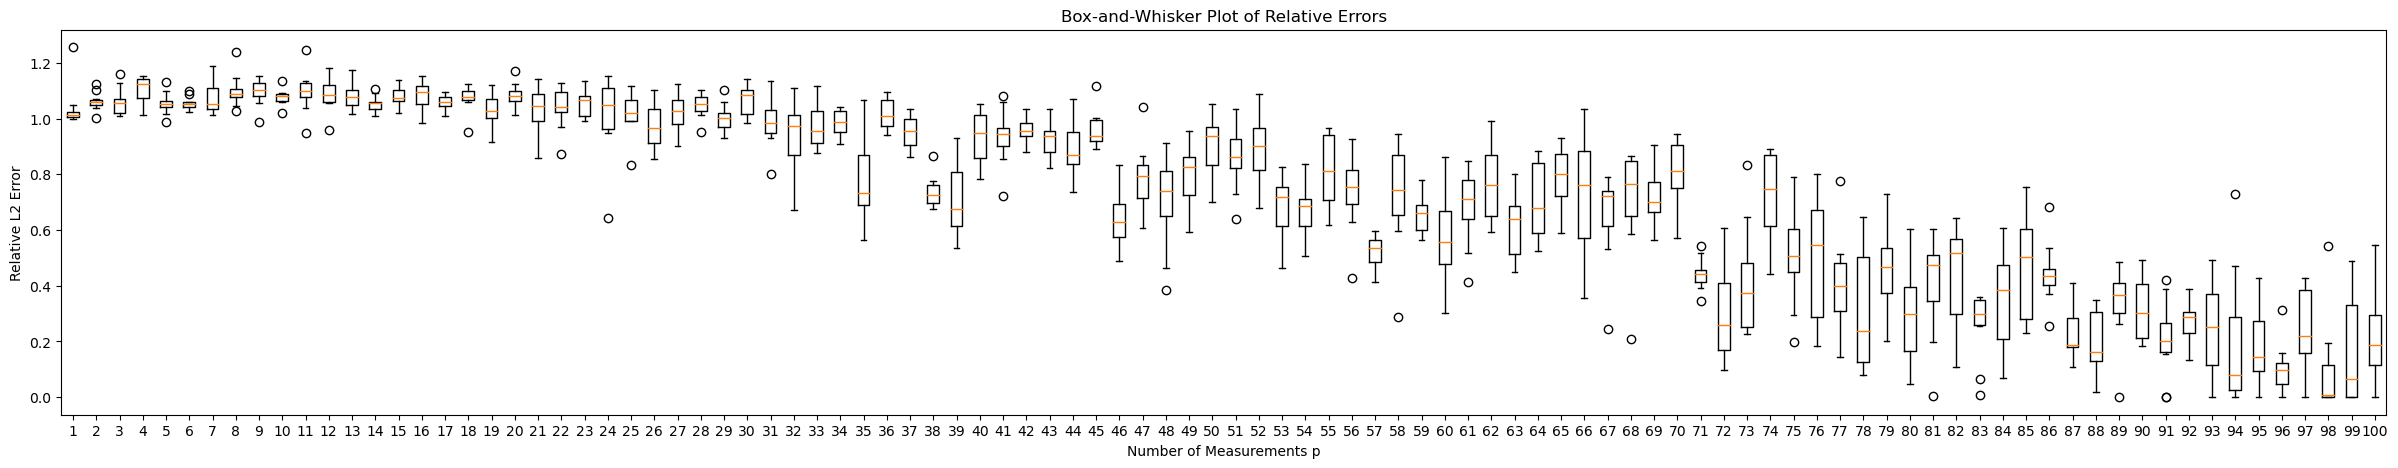

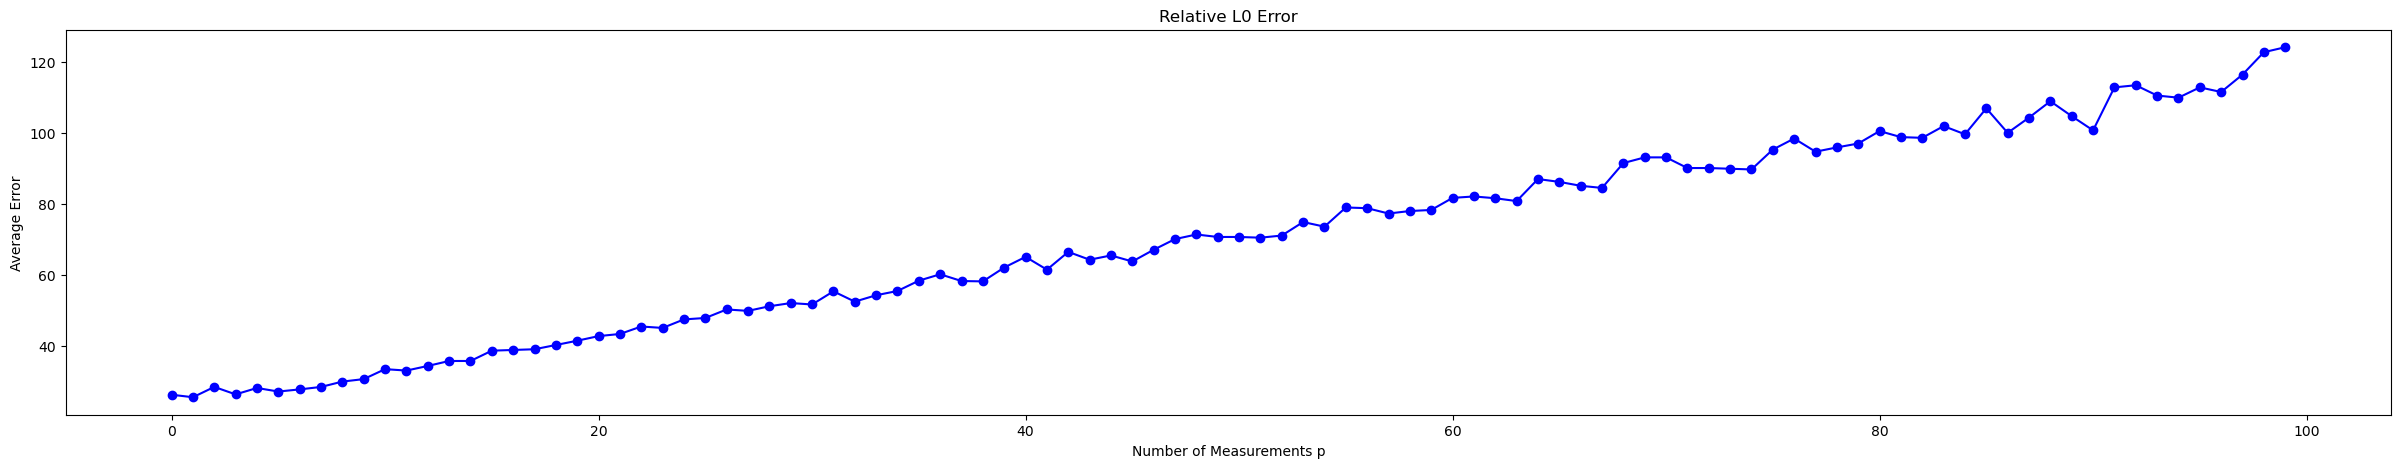

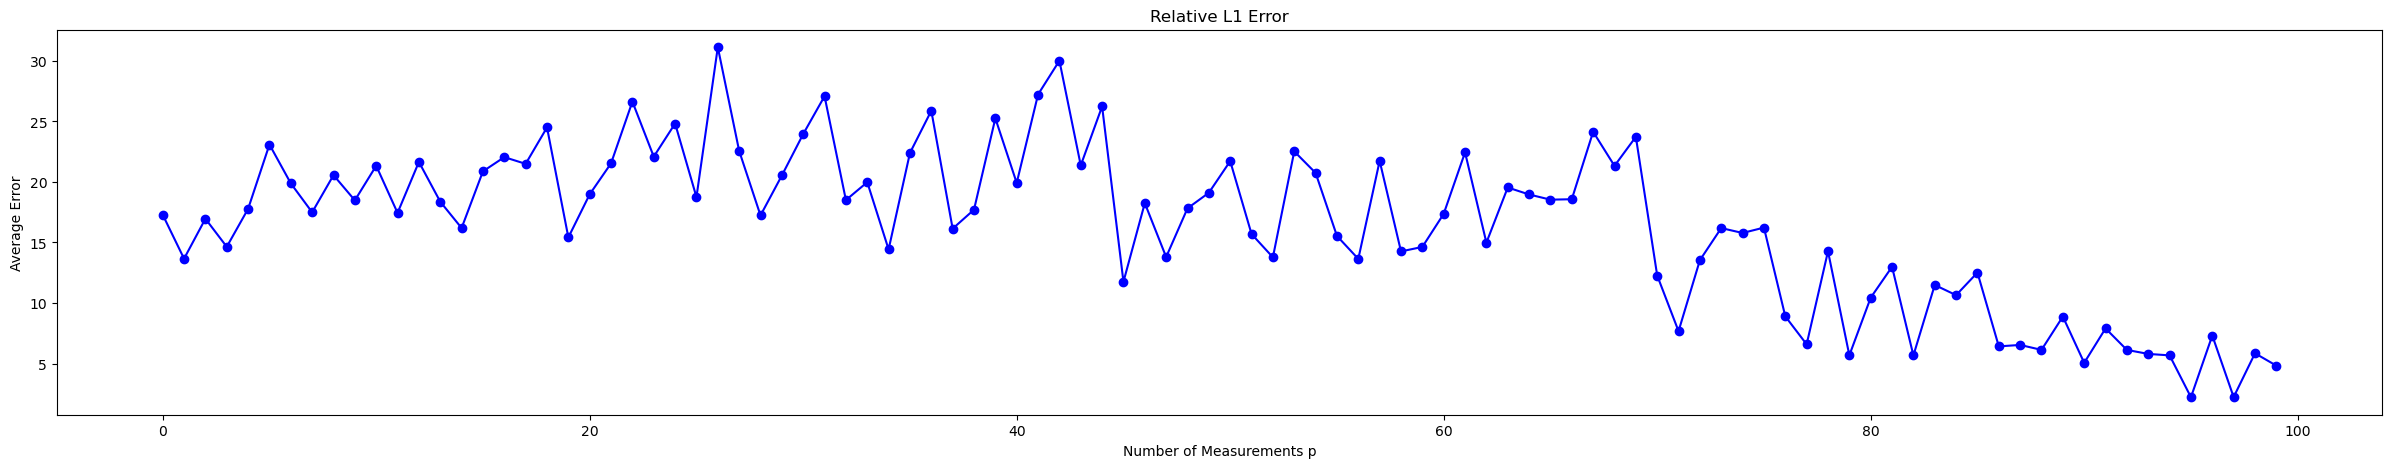

In [21]:
n = 1000
K = 20

random_process = np.random.normal

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


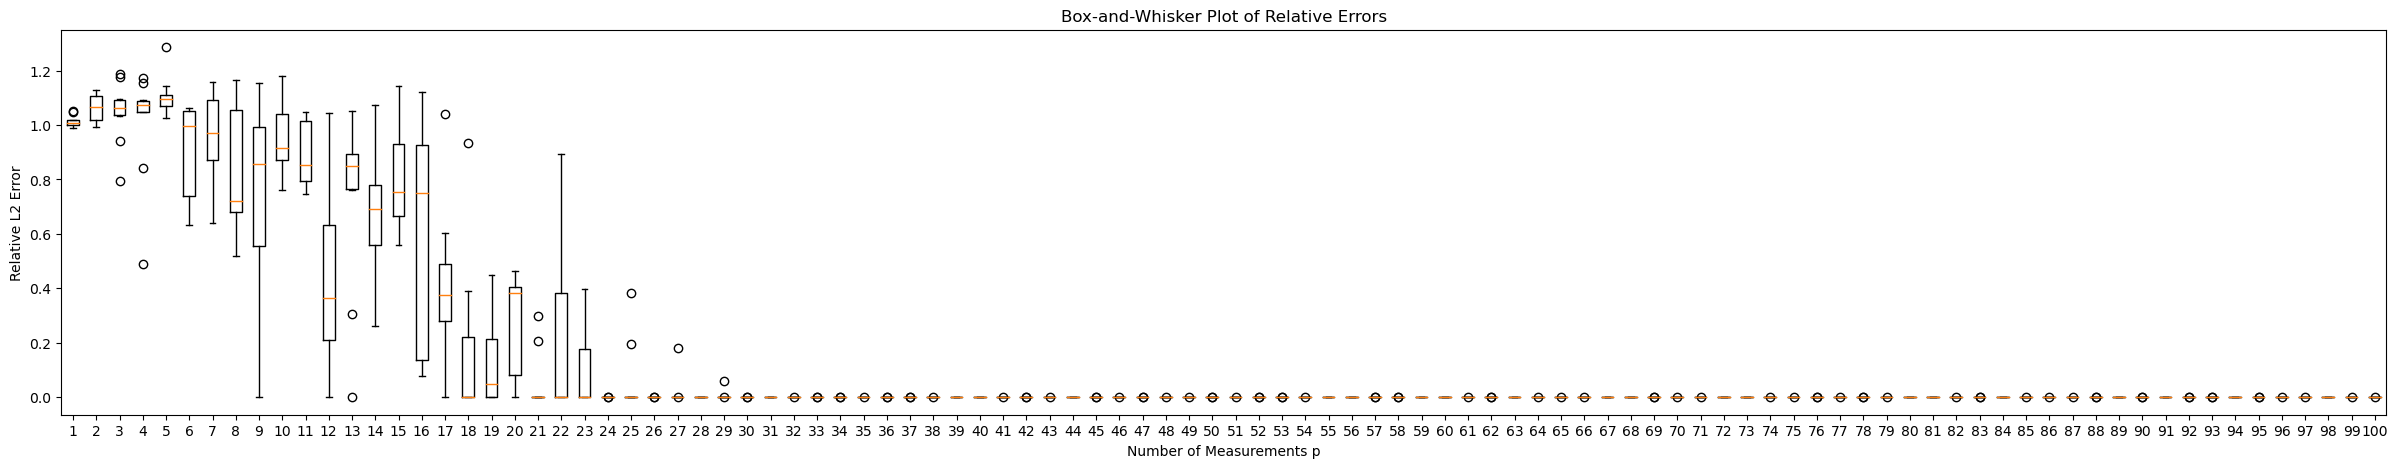

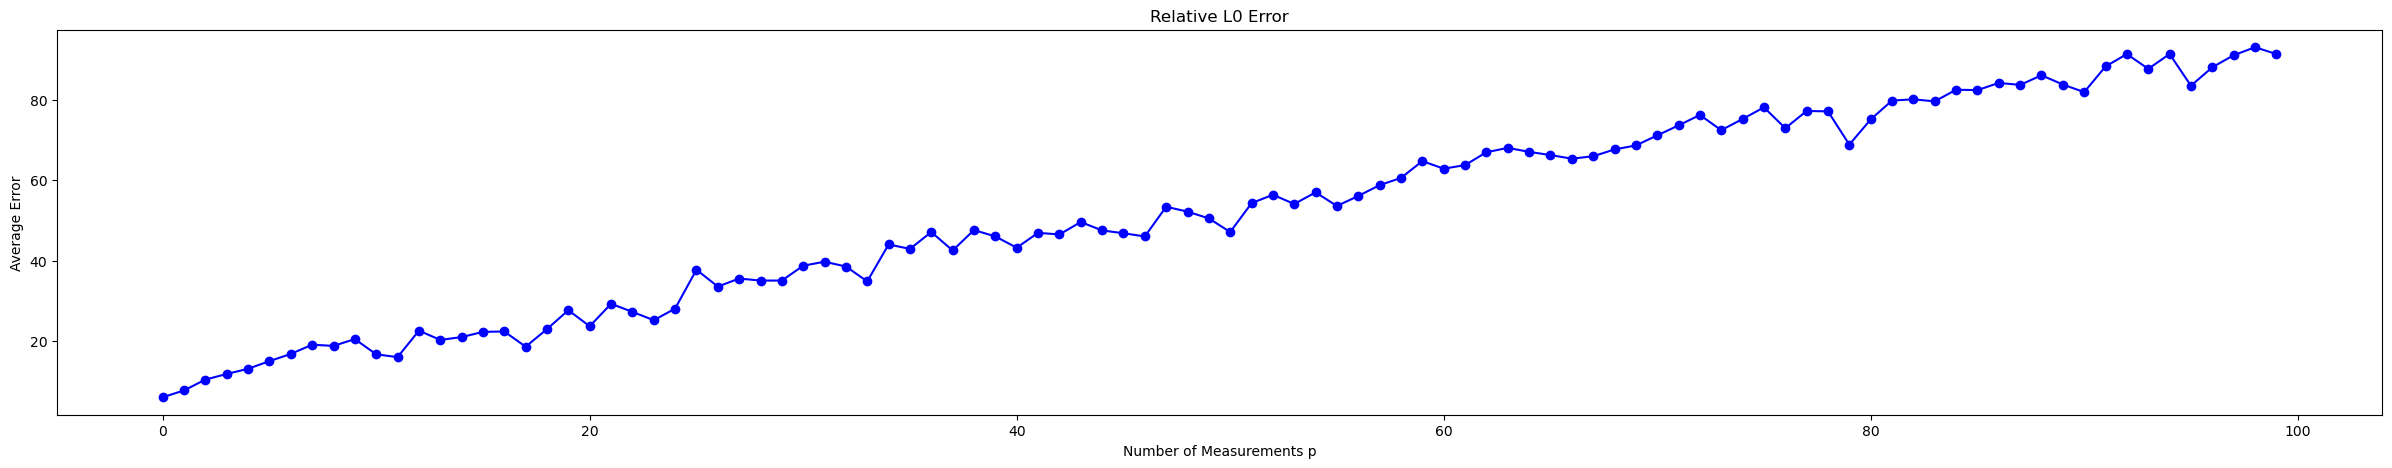

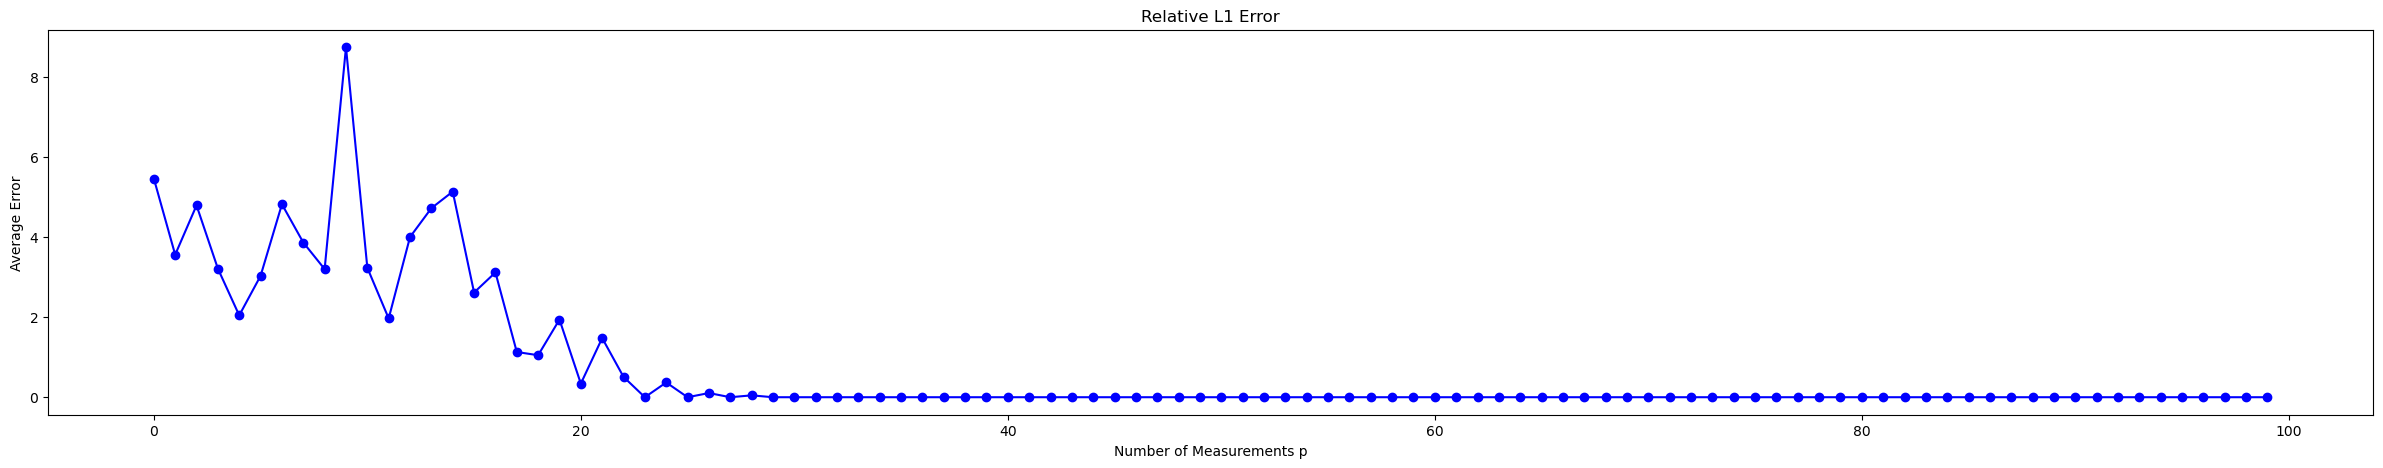

In [22]:
n = 100
K = 5

random_process = np.random.normal

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


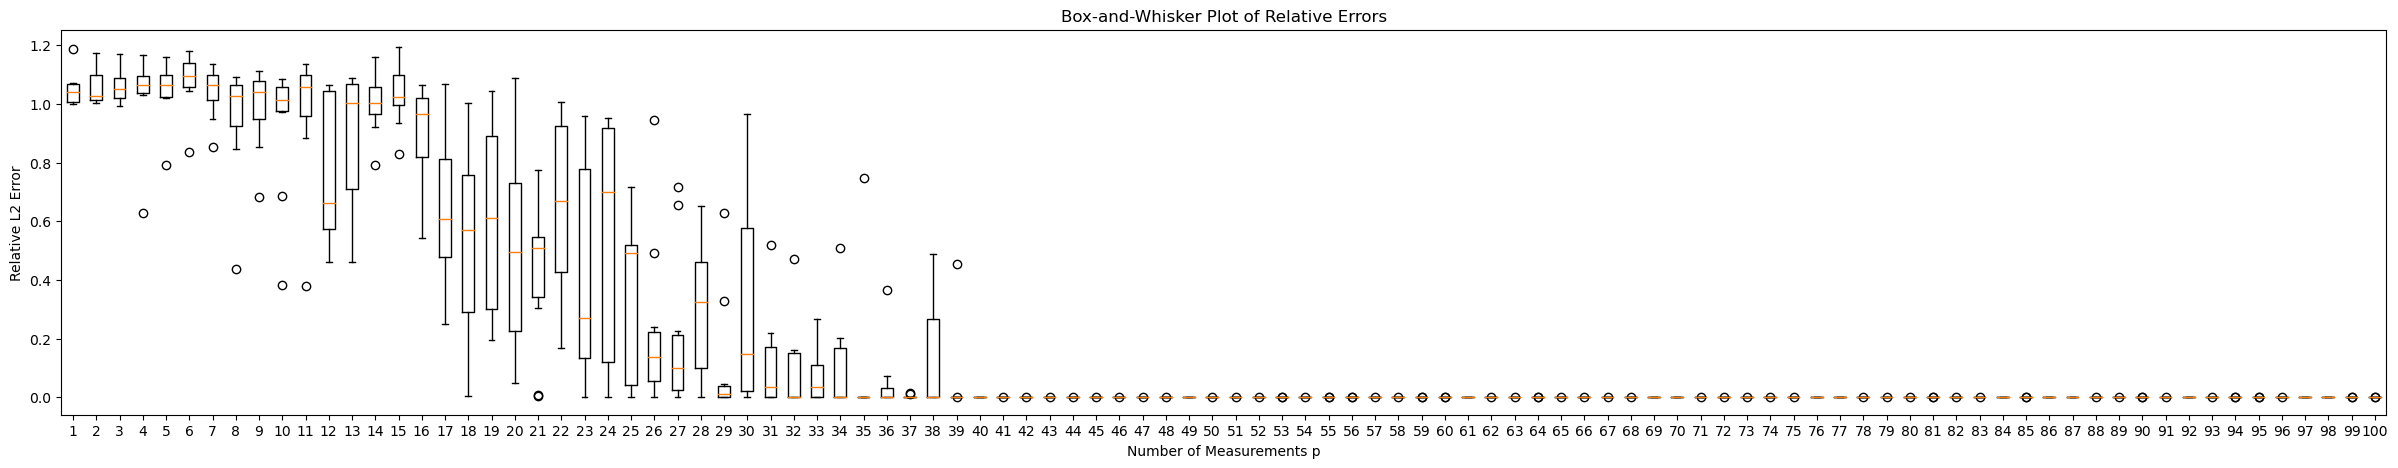

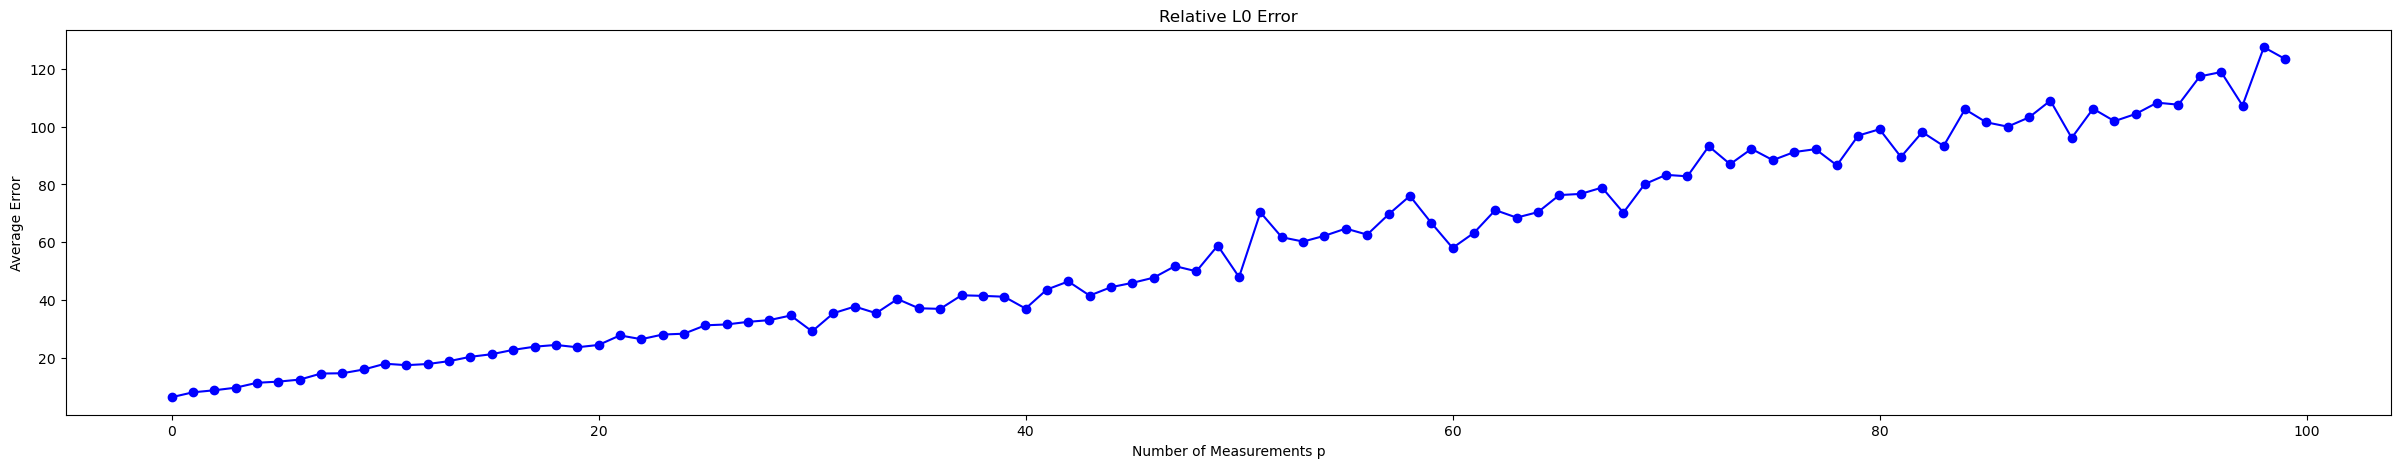

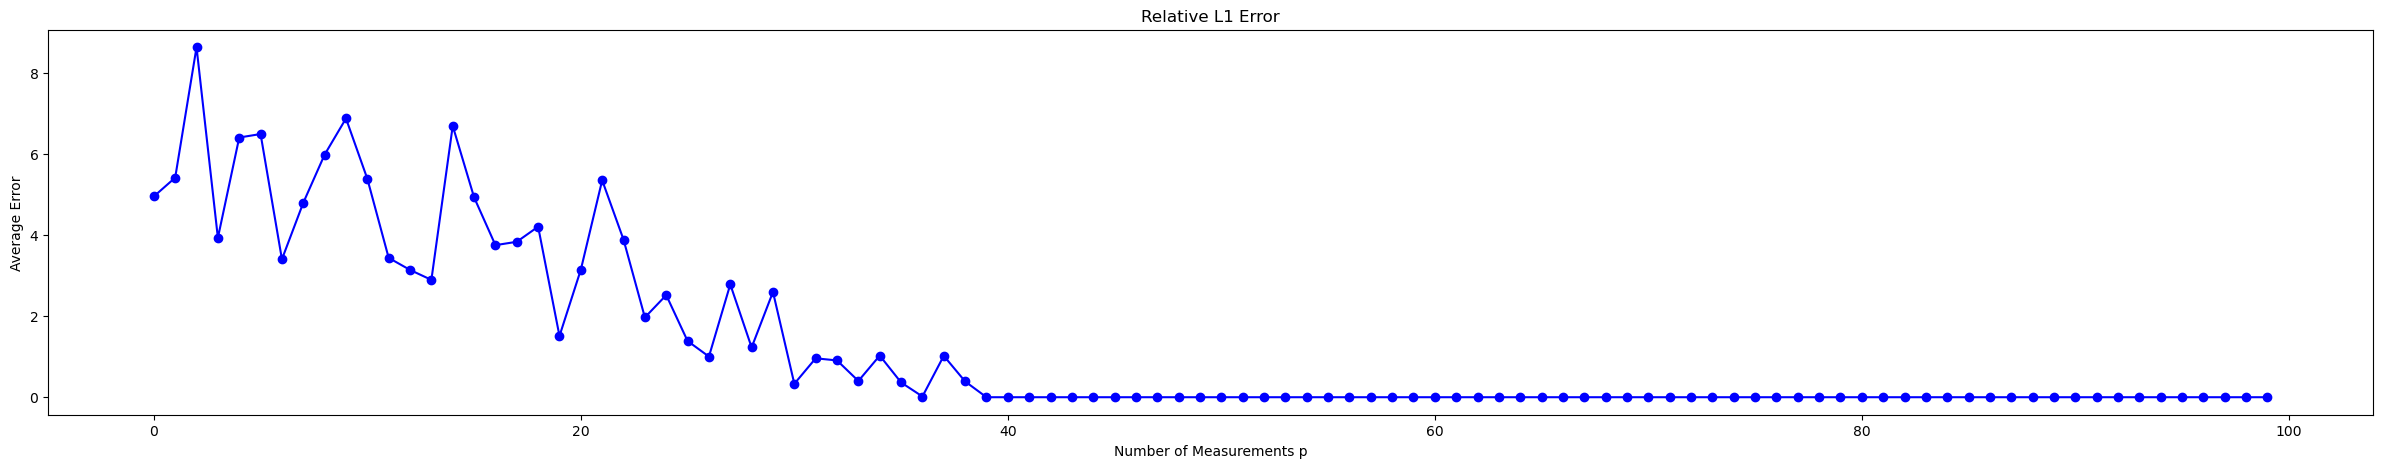

In [23]:
n = 500
K = 5

random_process = np.random.normal

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


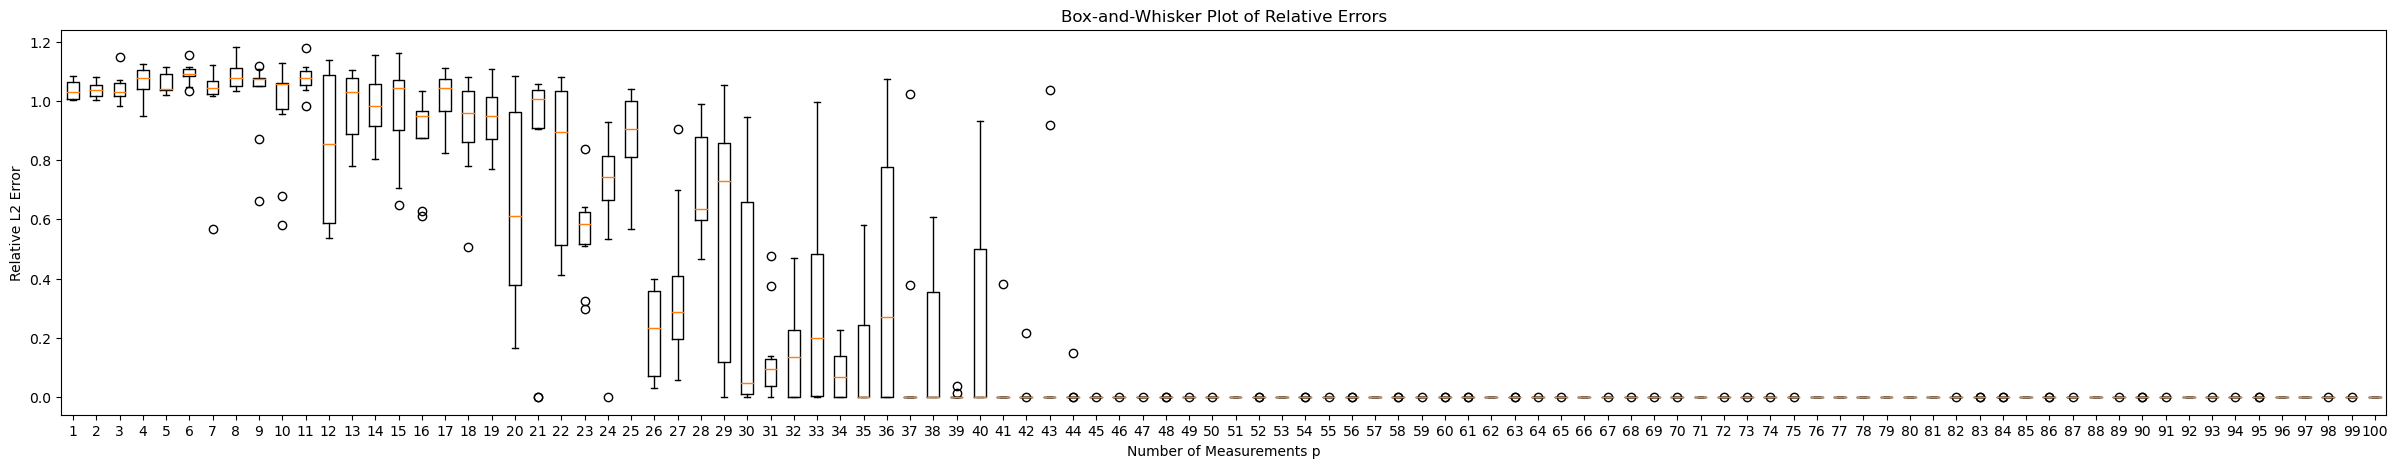

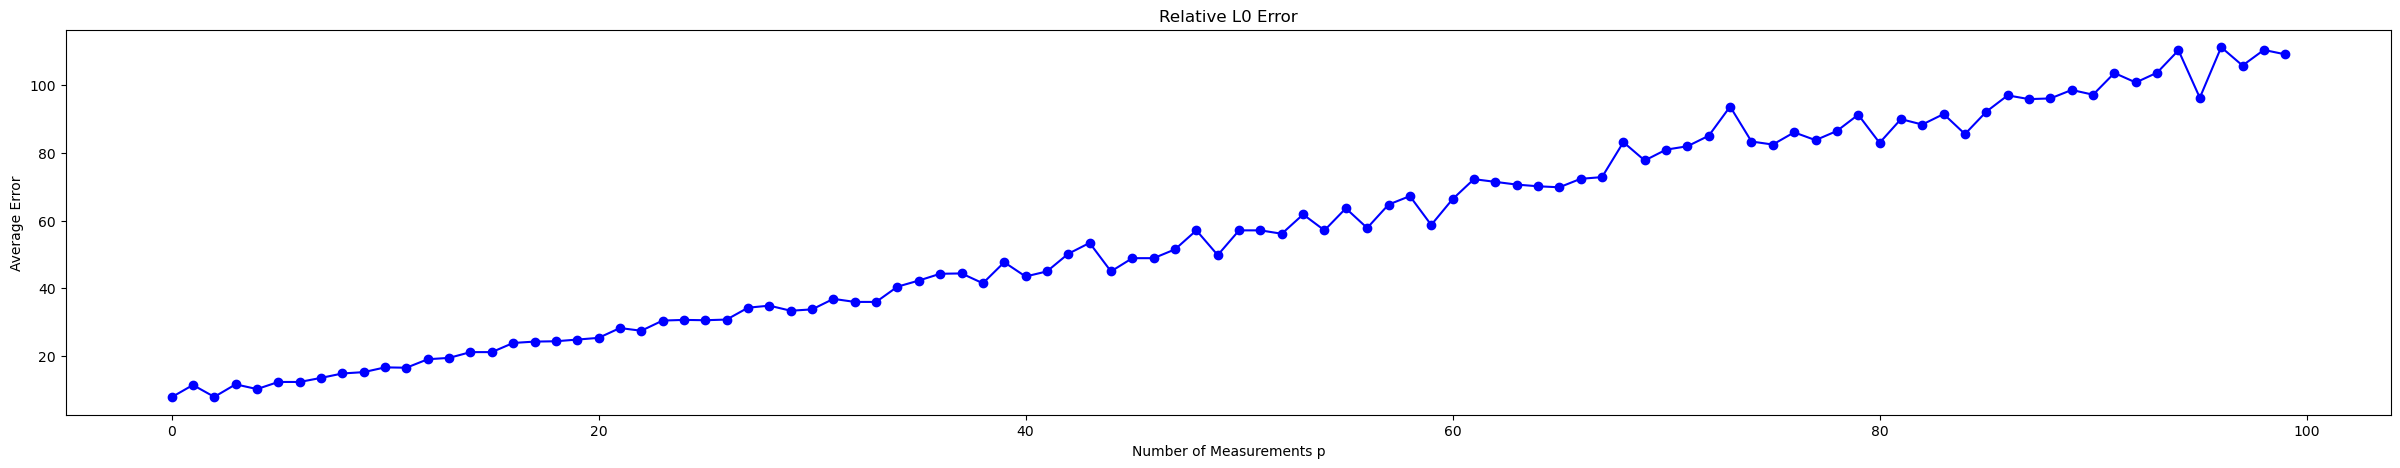

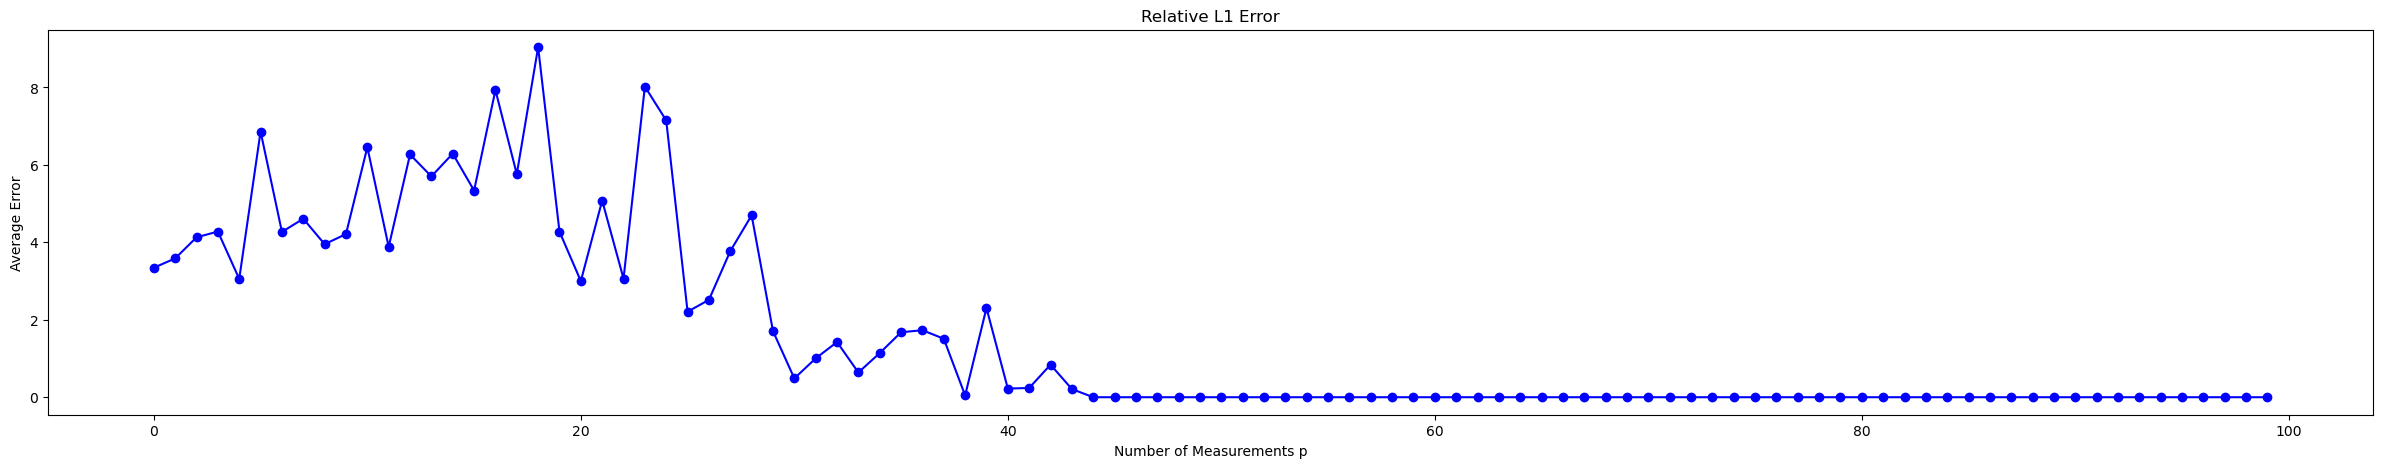

In [24]:
n = 1000
K = 5

random_process = np.random.normal

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


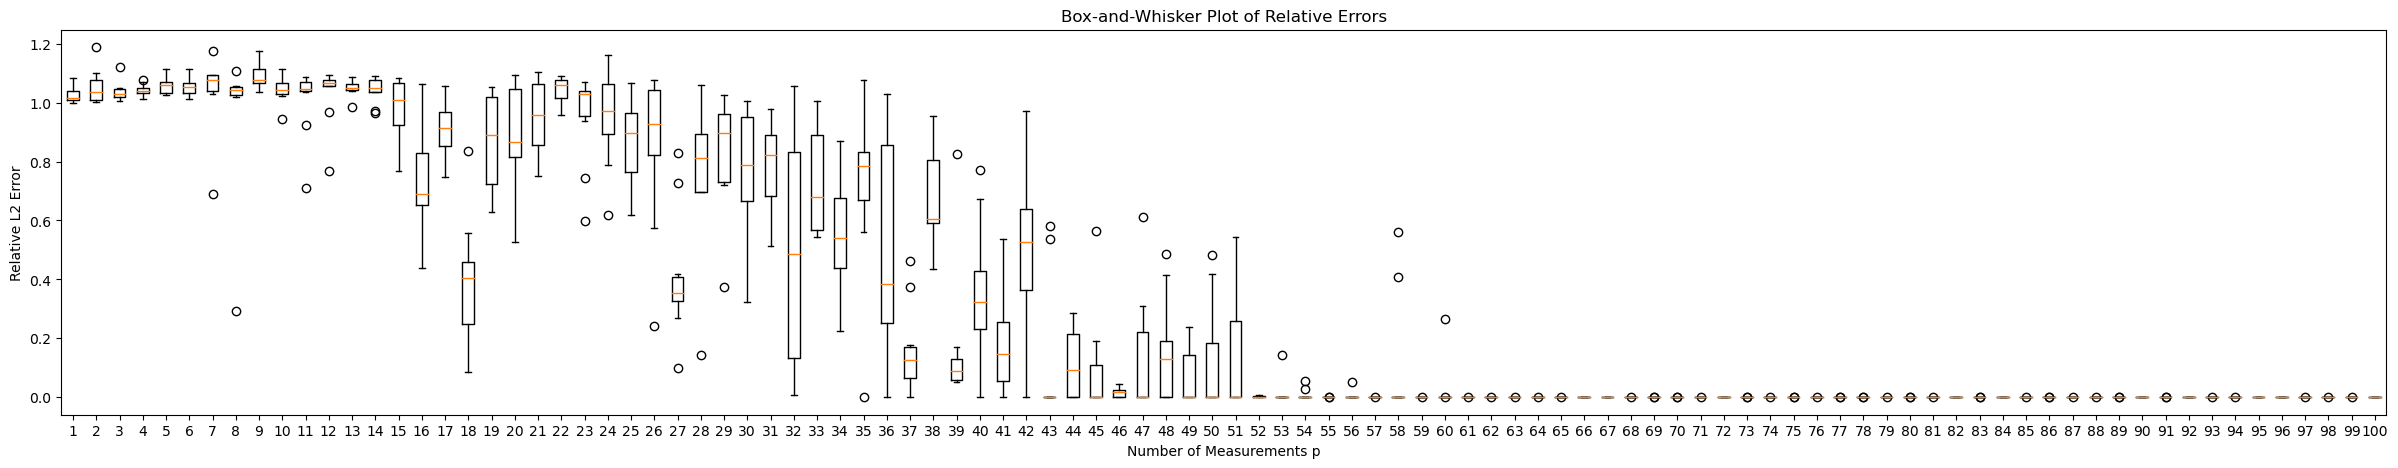

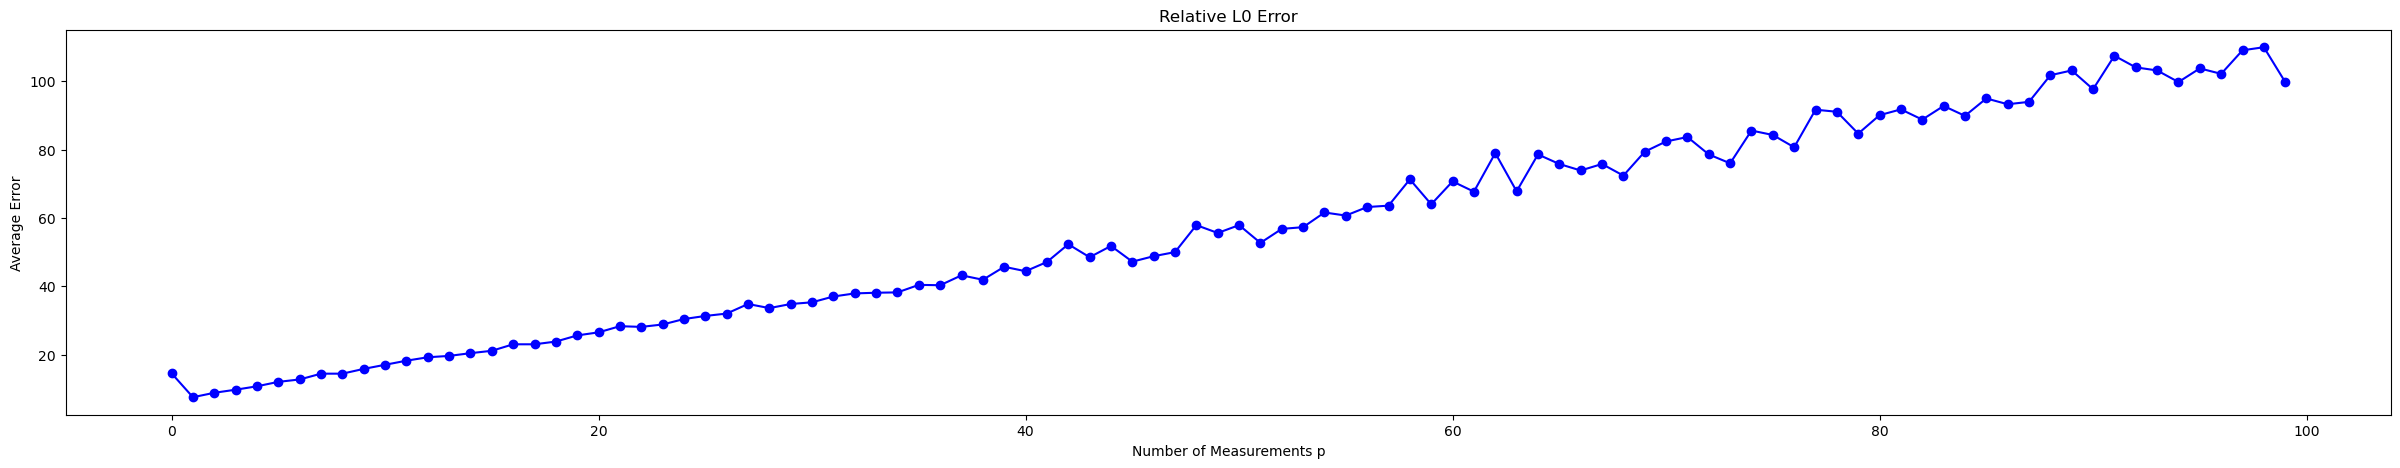

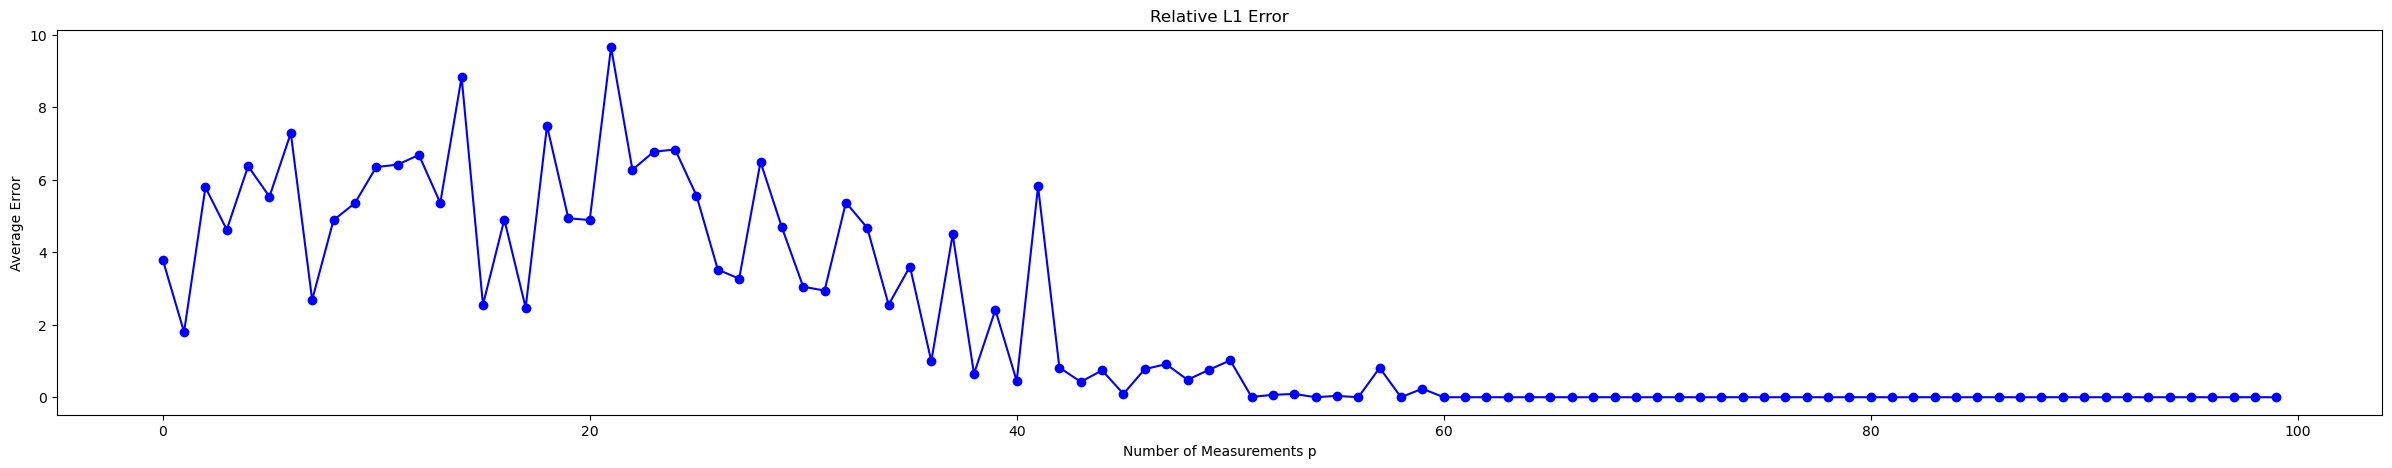

In [26]:
# n = 5000
# K = 5

# random_process = np.random.normal

# relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

# error_plot(relative_error, l0_norm, l1_norm)

In [27]:
# #code above takes a long time to run.
# import csv

# with open('relative_error_n_5000.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(relative_error)

# with open('l0_norm_n_5000.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(l0_norm)

# with open('l1_norm_n_5000.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(l1_norm)

# Exercise 3-4
Repeat the above exercise with a uniformly sampled random sample matrix. Also repeat with a Bernoulli random matrix and a matrix that comprises random single pixels. Plot the average relative errors for these different sampling matrices on the same plot (including the plot for Gaussian random
sampling). Discuss the trends.

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


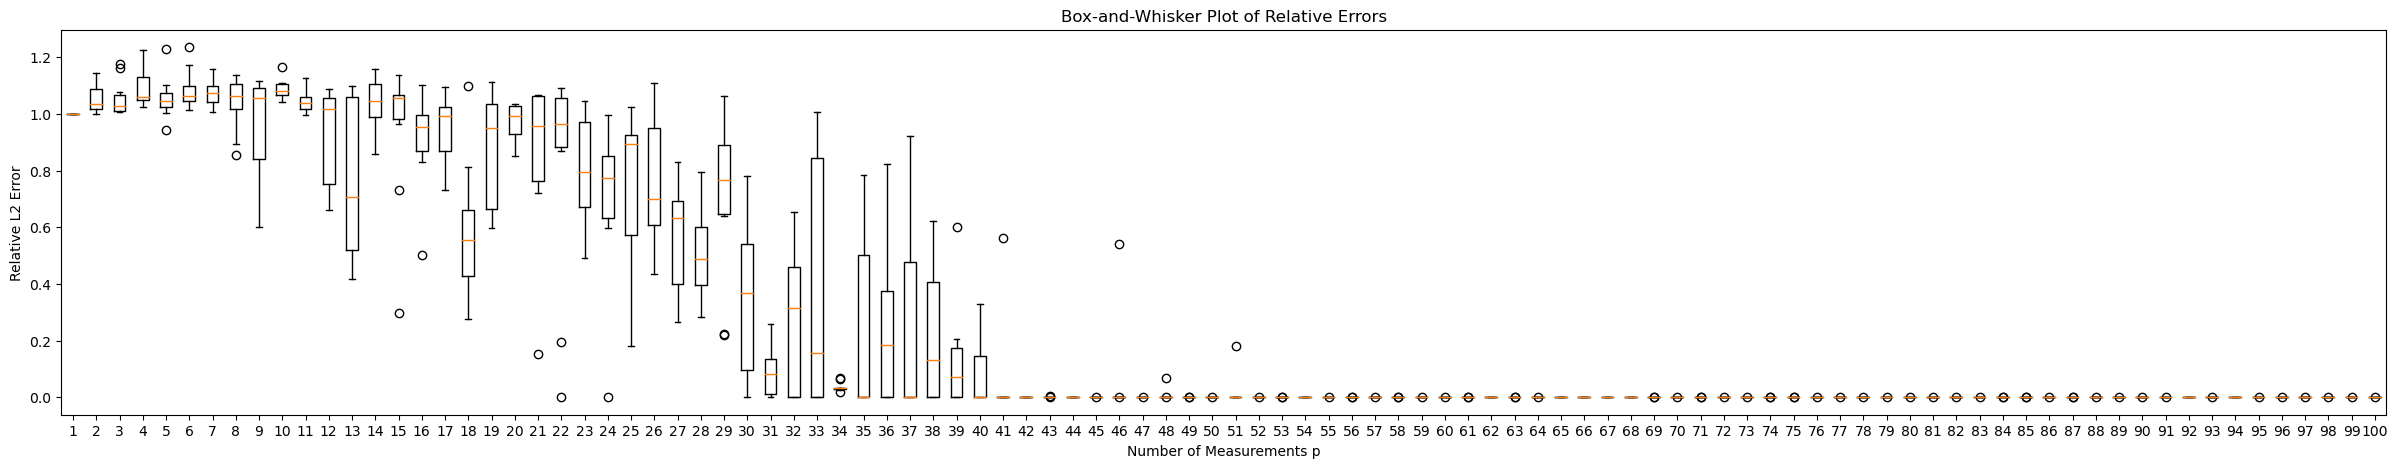

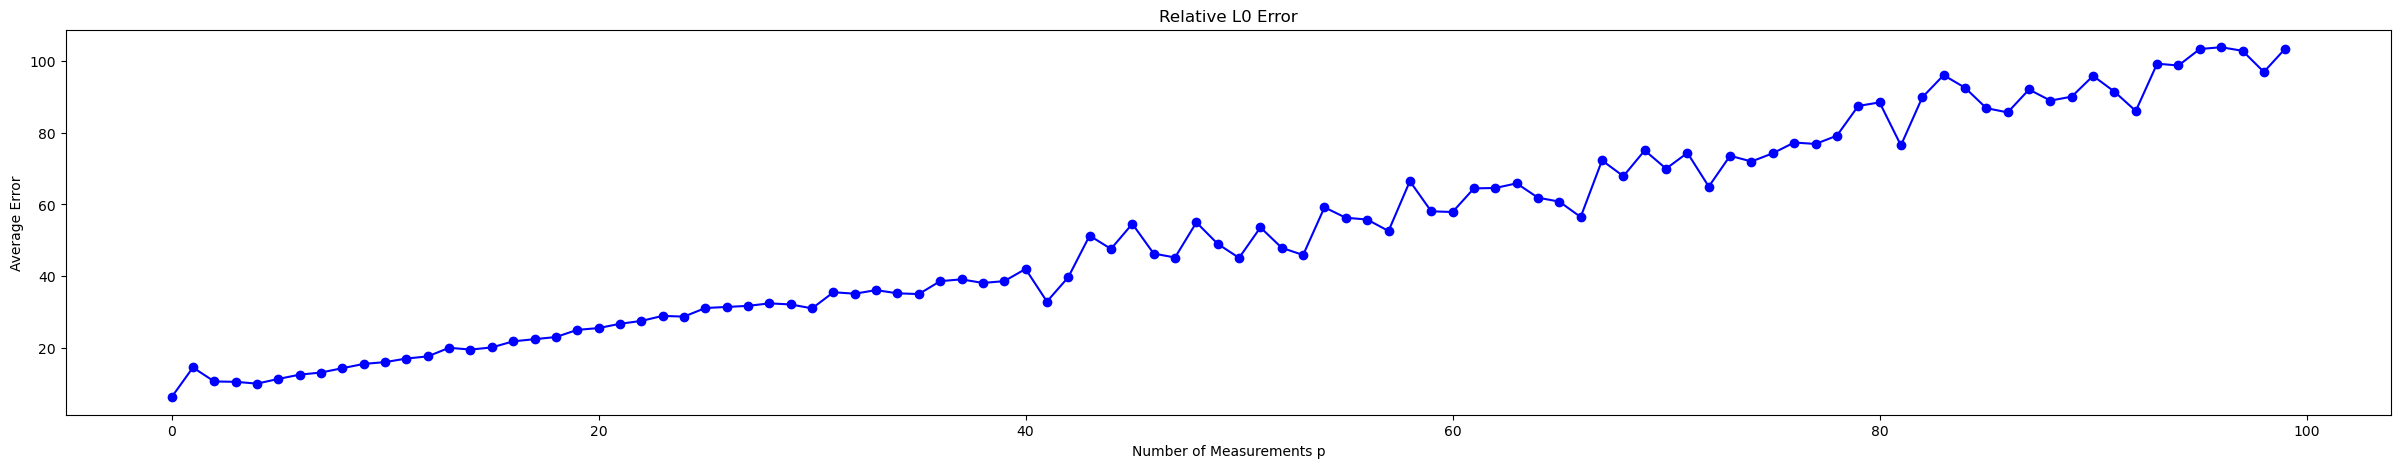

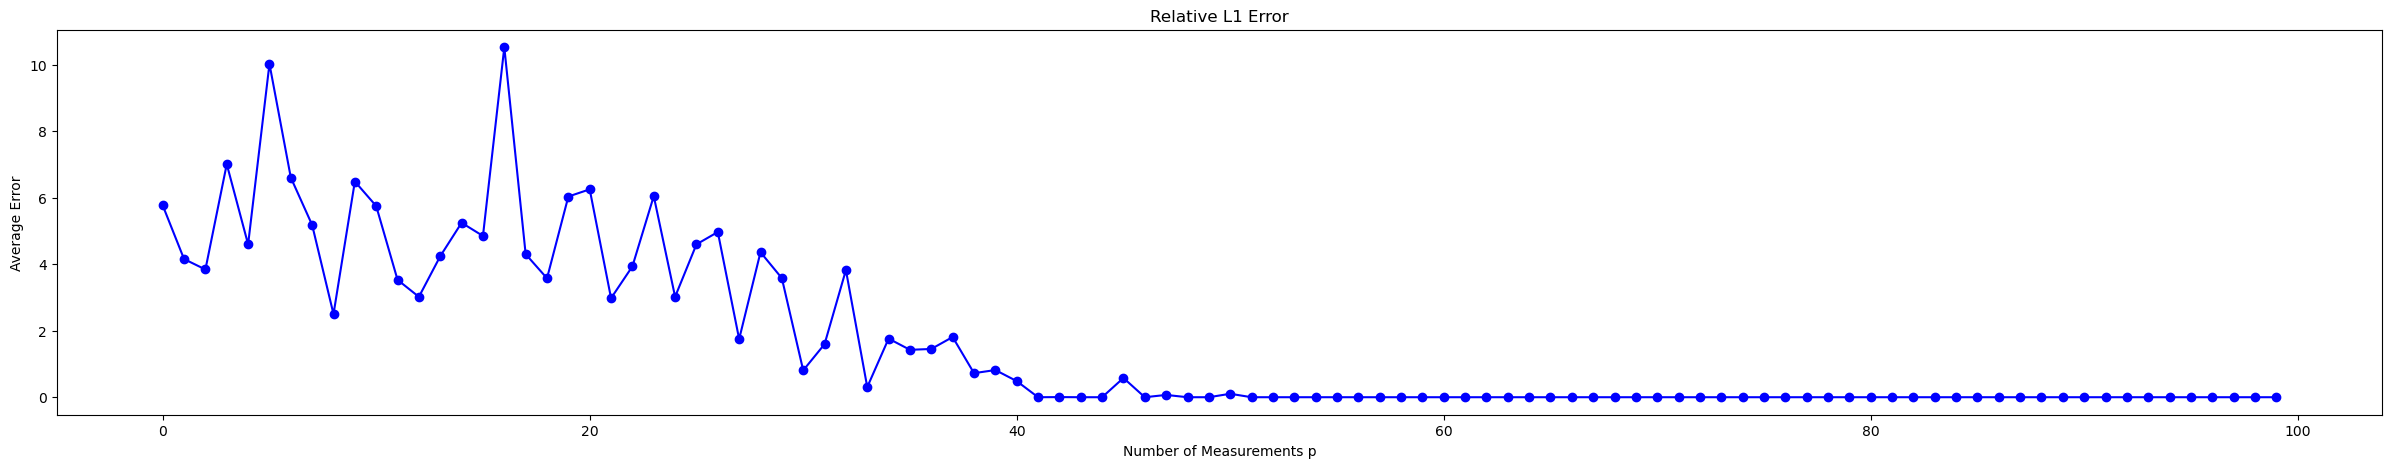

In [28]:
n = 1000
K = 5

random_process = np.random.uniform

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


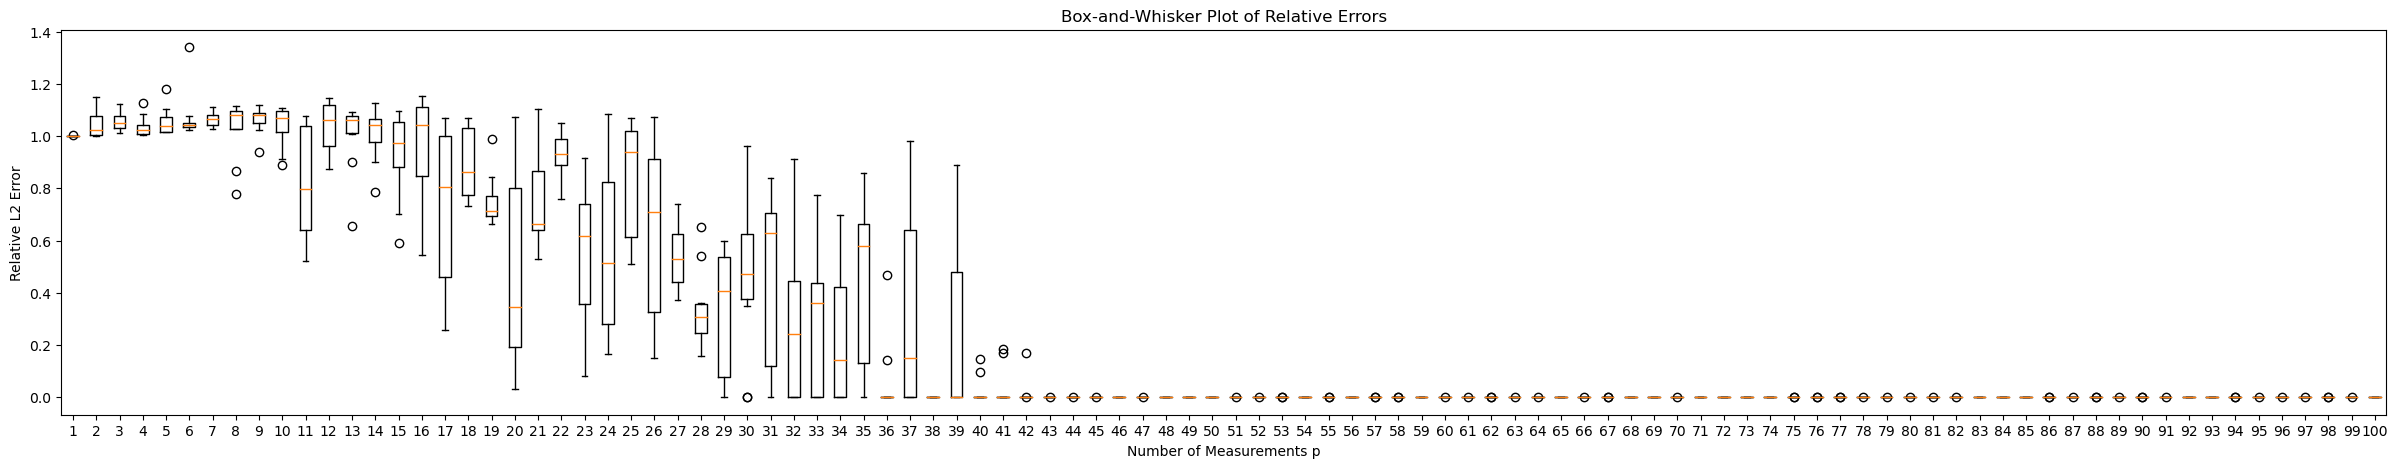

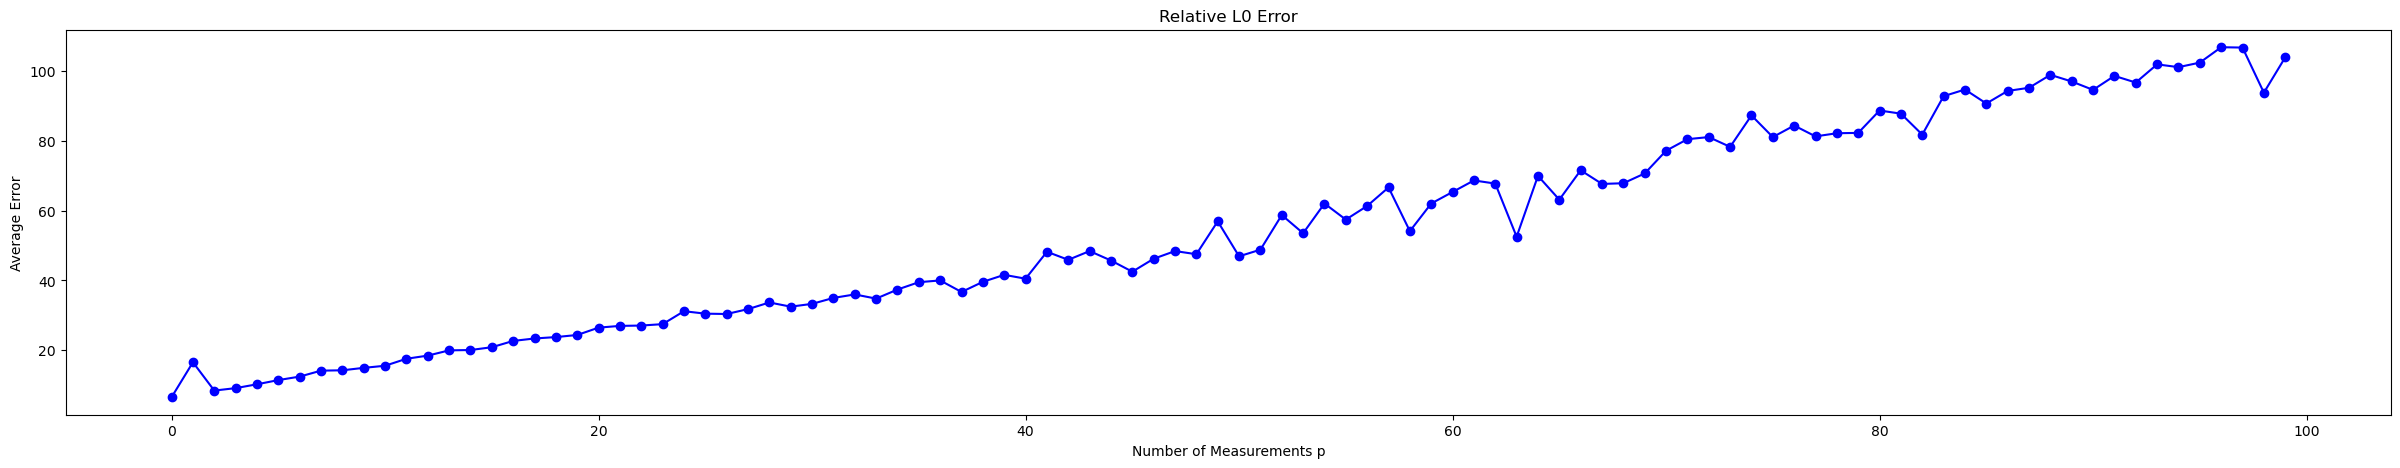

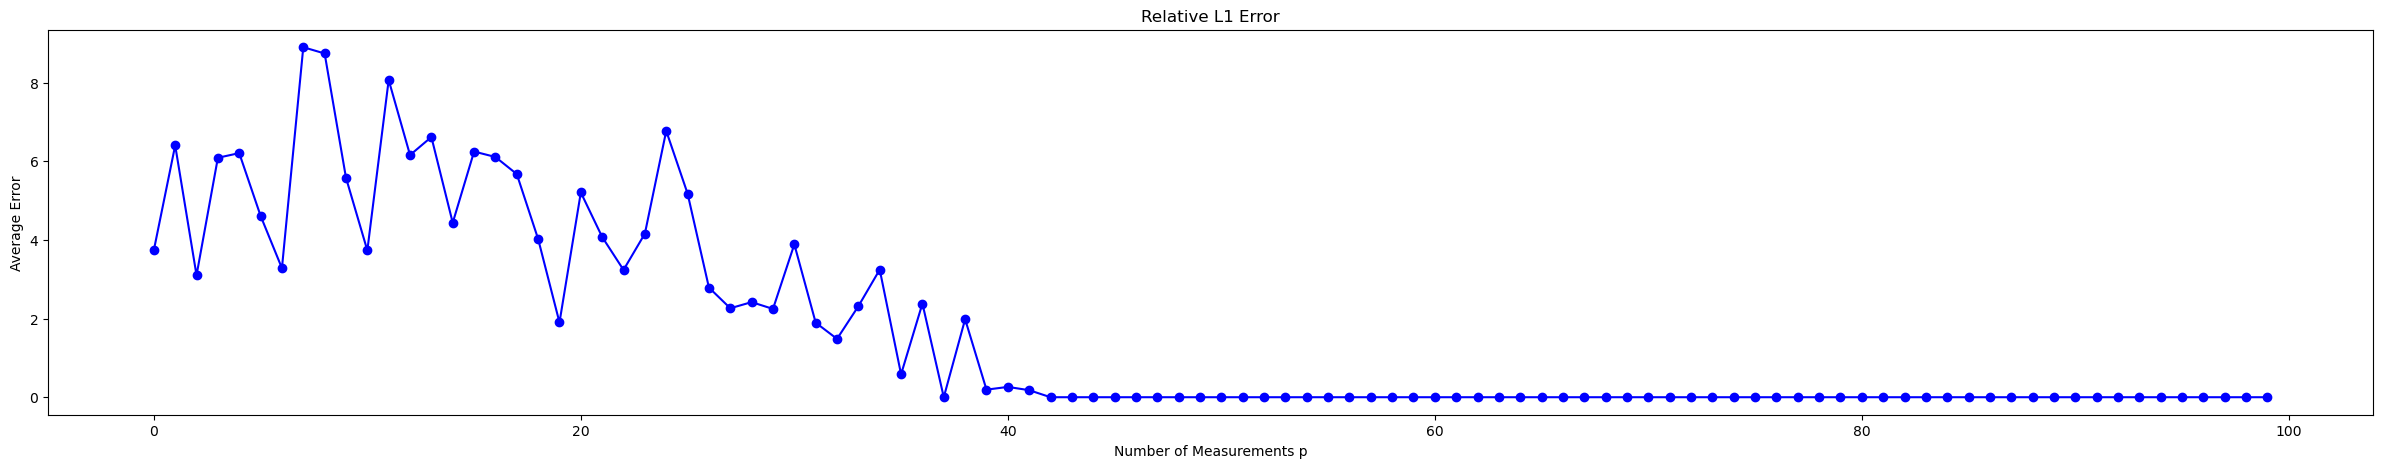

In [33]:
n = 1000
K = 5

random_process = np.random.binomial

relative_error, l0_norm, l1_norm = experiment(n, K, random_process, binomial = True)

error_plot(relative_error, l0_norm, l1_norm)

In [34]:
def random_single_pixel_matrix(size):
    matrix = np.zeros(size, dtype=int)
    random_row = np.random.randint(0, size[0])
    random_col = np.random.randint(0, size[1])
    
    matrix[random_row, random_col] = 1
    
    return matrix

10 / 100
20 / 100
30 / 100
40 / 100
50 / 100
60 / 100
70 / 100
80 / 100
90 / 100
100 / 100


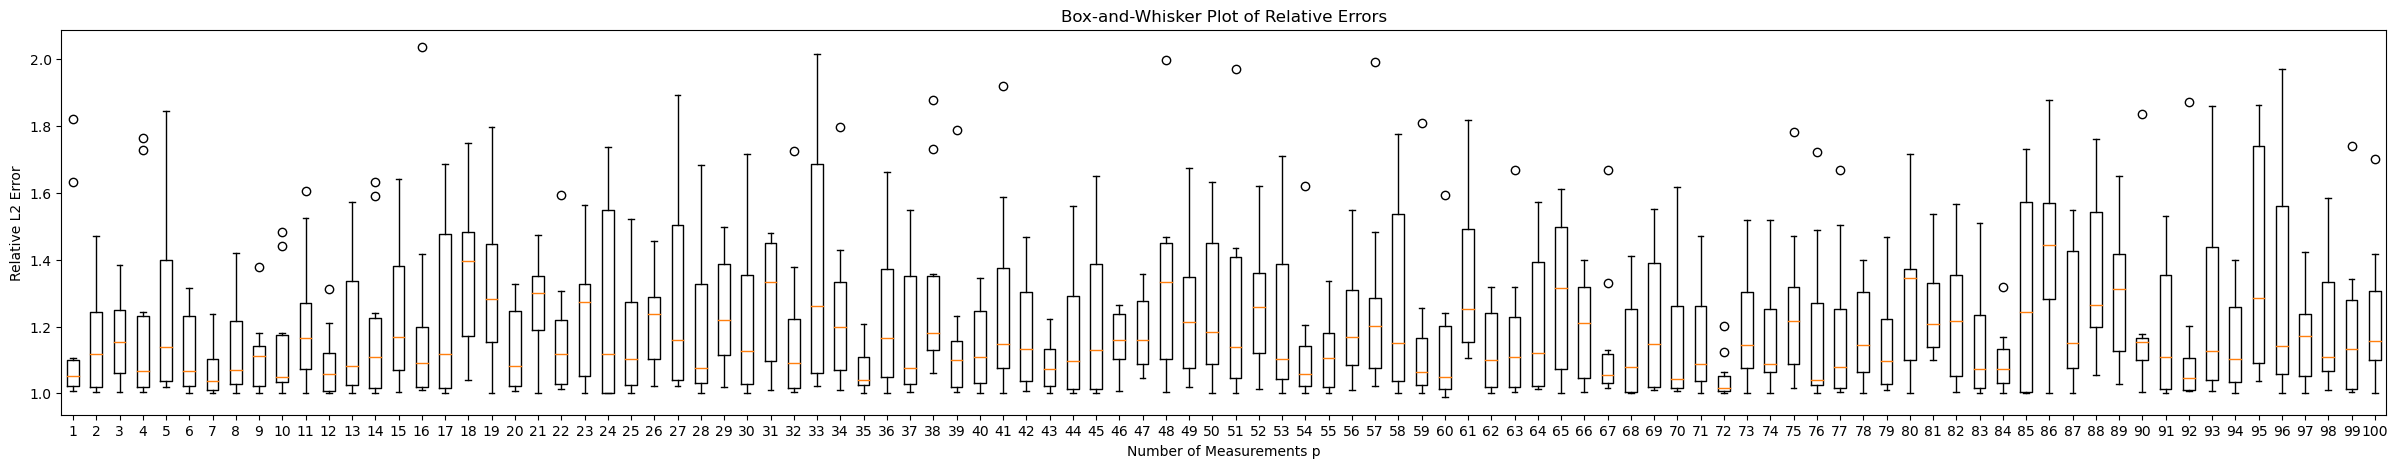

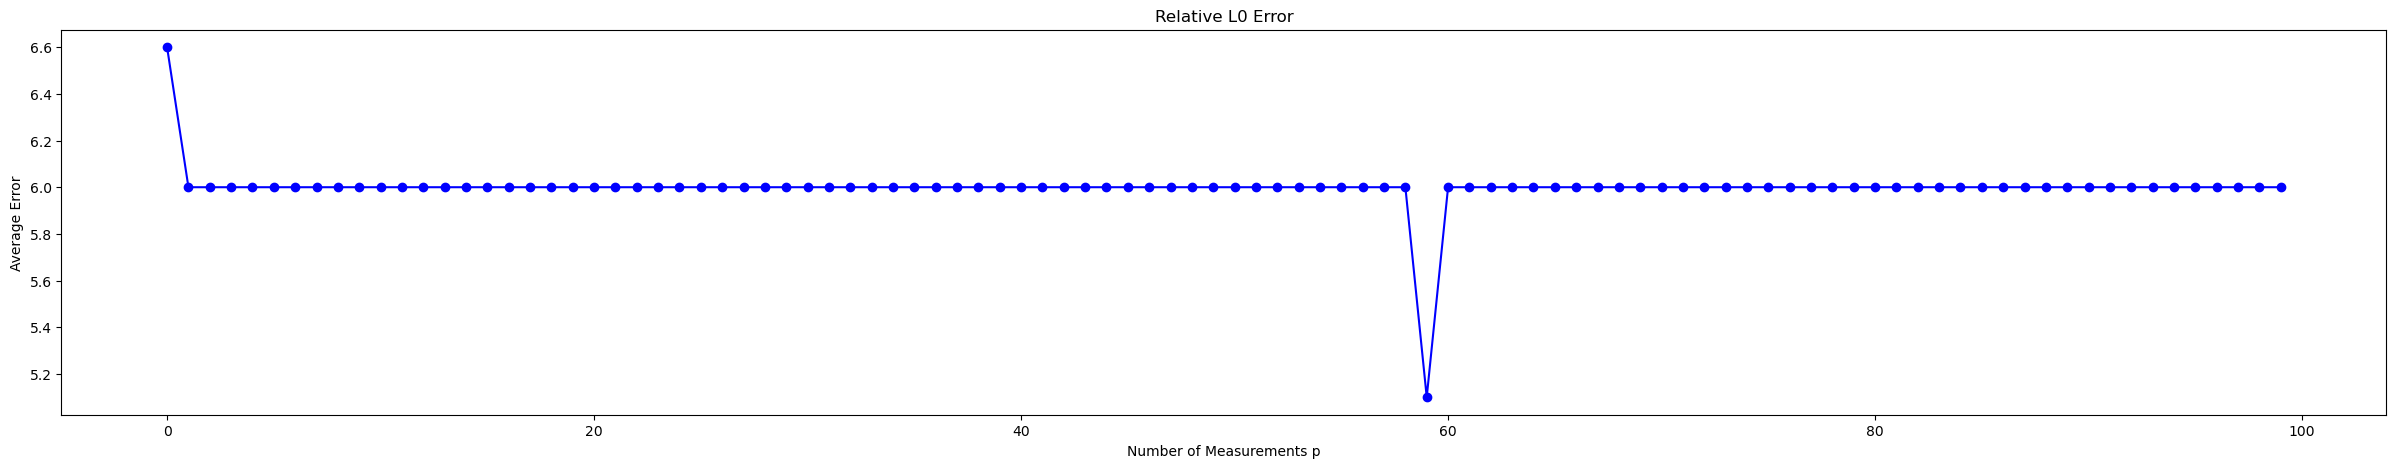

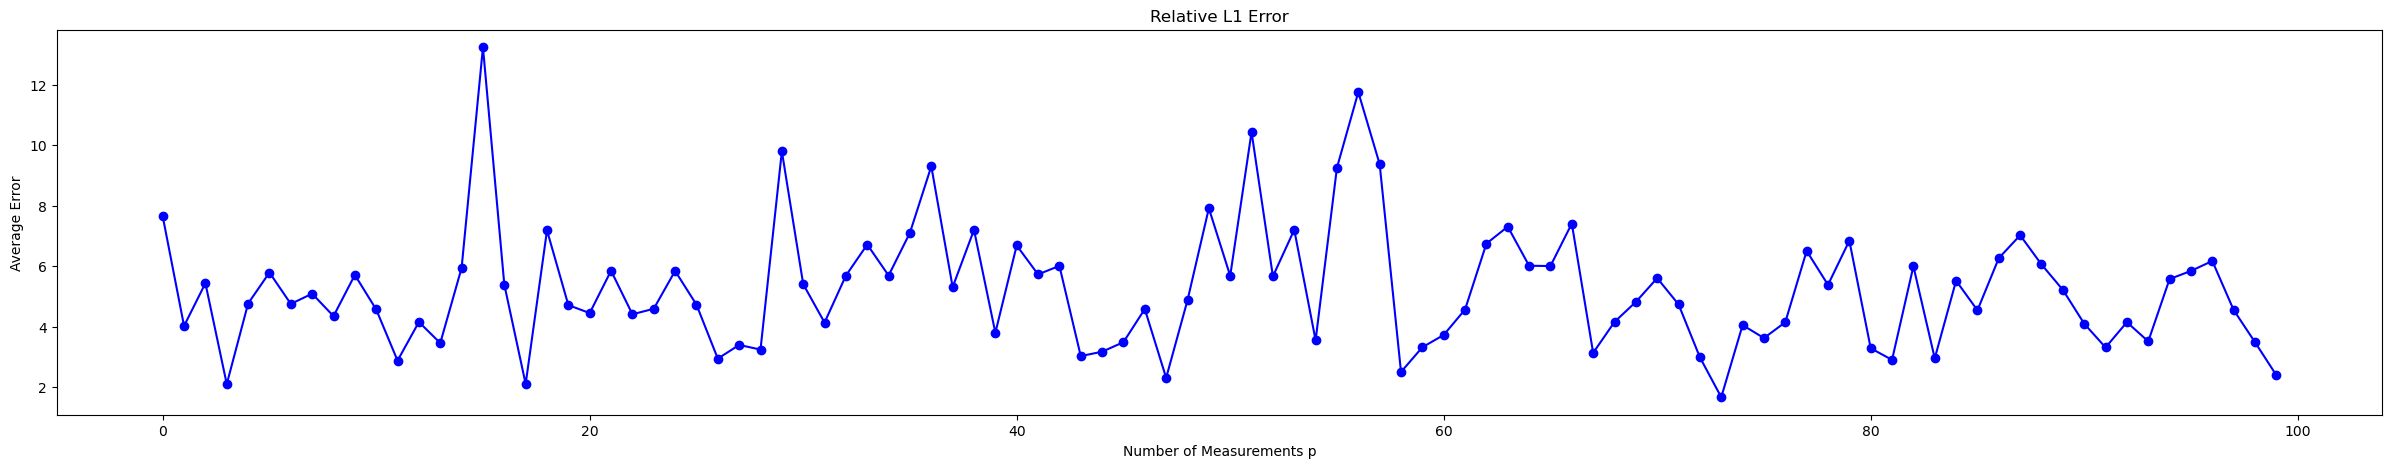

In [35]:
n = 1000
K = 5

random_process = random_single_pixel_matrix

relative_error, l0_norm, l1_norm = experiment(n, K, random_process)

error_plot(relative_error, l0_norm, l1_norm)

# Exercise 3-5

Generate a DFT matrix $\Psi$ for $n = 512$. We will use the basis for compressed sensing, and we will compute the incoherence of this basis and different measurement matrices. For $p=16$, create different random measurement matrices $C$ given by Gaussian random measurements, Bernoulli random measurements, and random single-pixel measurements. For each matrix, normalize the length of each row to 1. Now, for each measurement matrix type, compute the incoherence $\mu(C,\Psi)$. Repeat this for many random instances of each $C$ matrix type and compare the histogram of incoherence values for each matrix type. Further, compare the histogram of each inner product $\sqrt{n}\langle c_i,\psi_j\rangle$ for each matrix type. Discuss any trends and the implications for compressed sensing with these measurement matrices. Are there other factors that are relevant for the sensing matrix?


In [60]:
from scipy.linalg import dft

n = 512
p = 16

Psi = dft(n)

def normalize_rows(matrix):
    return matrix / np.linalg.norm(matrix, axis=1, keepdims=True)

Psi = normalize_rows(Psi)

def gaussian_random_matrix(p, n):
    return normalize_rows(np.random.randn(p, n))

def bernoulli_random_matrix(p, n):
    return normalize_rows(np.random.choice([-1, 1], size=(p, n)))

def single_pixel_random_matrix(p, n):
    identity_matrix = np.eye(n)
    indices = np.random.choice(n, p, replace=False)
    return normalize_rows(identity_matrix[indices])

def incoherence(C, Psi):
    inner_products = np.abs(np.dot(C, Psi.T))
    return np.max(inner_products)

def inner_product_distribution(C, Psi):
    return np.sqrt(n) * np.abs(np.dot(C, Psi.T))

In [61]:
num_trials = 100  # Number of random instances

# Containers for incoherence values
gaussian_incoherence = []
bernoulli_incoherence = []
single_pixel_incoherence = []

# Containers for inner product distributions
gaussian_inner_product_dist = []
bernoulli_inner_product_dist = []
single_pixel_inner_product_dist = []

for _ in range(num_trials):
    # Gaussian
    C_gaussian = gaussian_random_matrix(p, n)
    gaussian_incoherence.append(incoherence(C_gaussian, Psi))
    gaussian_inner_product_dist.append(inner_product_distribution(C_gaussian, Psi).flatten())
    
    # Bernoulli
    C_bernoulli = bernoulli_random_matrix(p, n)
    bernoulli_incoherence.append(incoherence(C_bernoulli, Psi))
    bernoulli_inner_product_dist.append(inner_product_distribution(C_bernoulli, Psi).flatten())
    
    # Single Pixel
    C_single_pixel = single_pixel_random_matrix(p, n)
    single_pixel_incoherence.append(incoherence(C_single_pixel, Psi))
    single_pixel_inner_product_dist.append(inner_product_distribution(C_single_pixel, Psi).flatten())

In [62]:
# Since we want the histogram for all inner products, we concatenate the lists
gaussian_inner_product_dist = np.concatenate(gaussian_inner_product_dist)
bernoulli_inner_product_dist = np.concatenate(bernoulli_inner_product_dist)
single_pixel_inner_product_dist = np.concatenate(single_pixel_inner_product_dist)

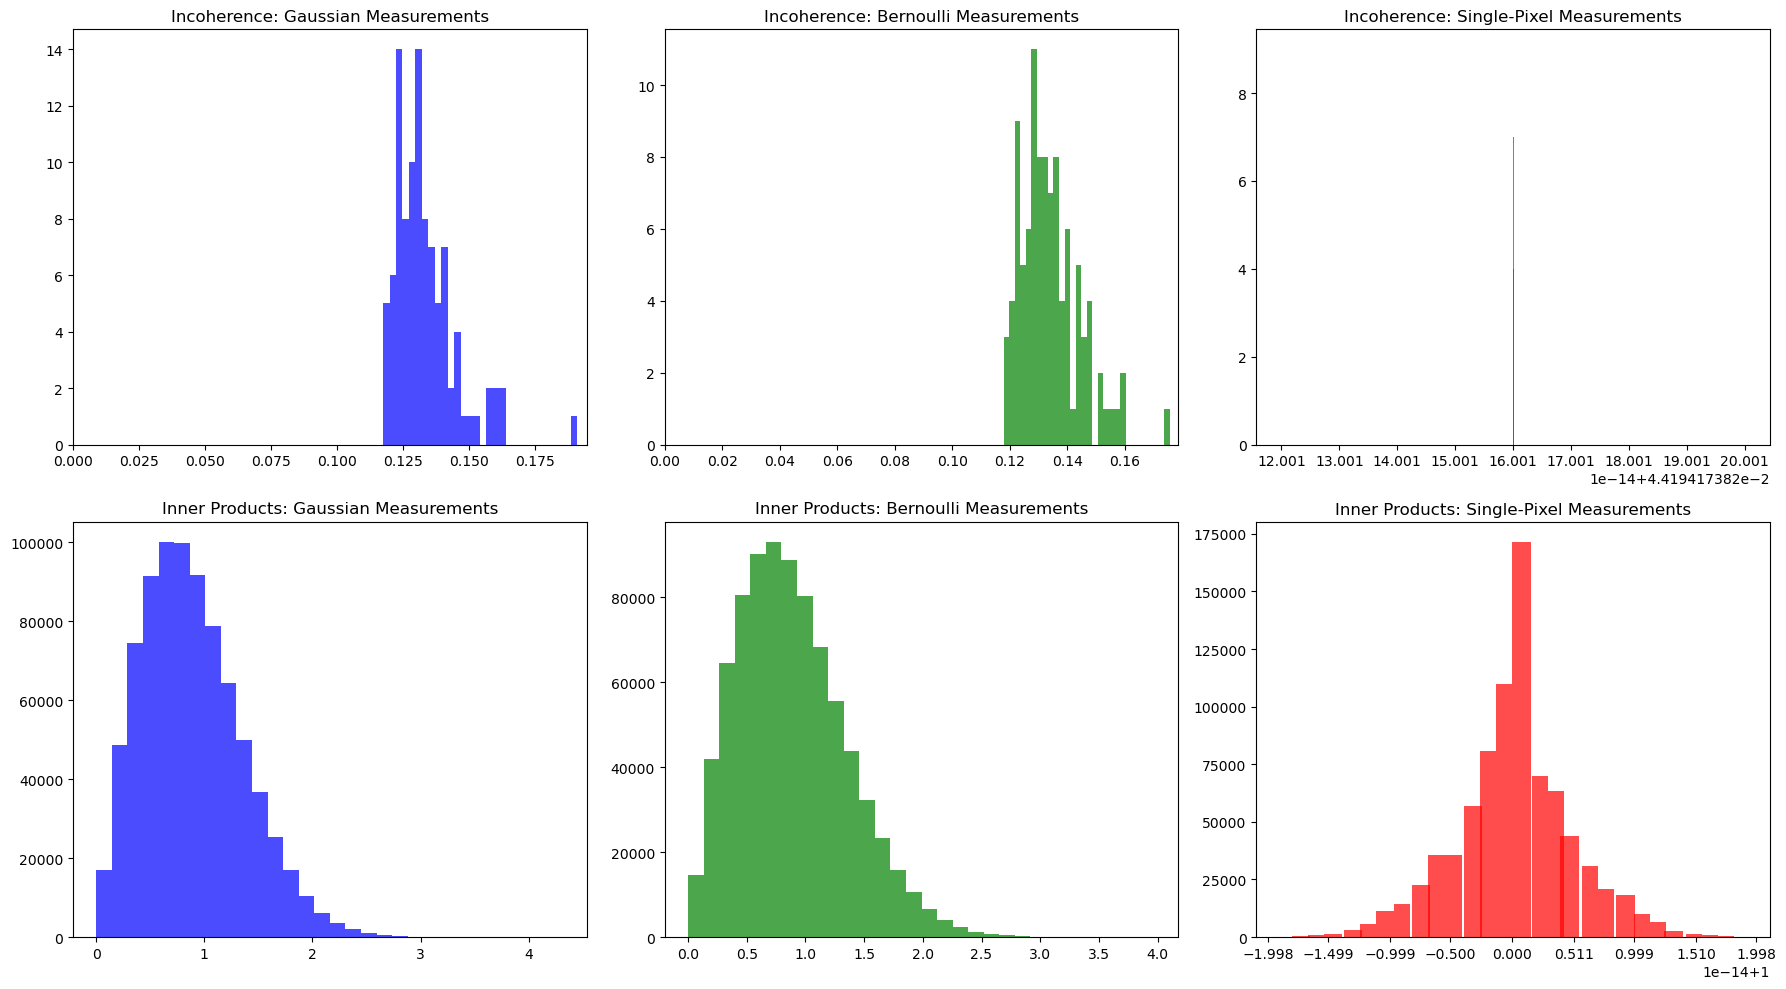

In [63]:
fig, ax = plt.subplots(2, 3, figsize=(18, 10))

# Incoherence histograms
ax[0, 0].hist(gaussian_incoherence, bins=30, color='blue', alpha=0.7, label='Gaussian')
ax[0, 0].set_title('Incoherence: Gaussian Measurements')
ax[0, 0].set_xlim(left=0)
ax[0, 1].hist(bernoulli_incoherence, bins=30, color='green', alpha=0.7, label='Bernoulli')
ax[0, 1].set_title('Incoherence: Bernoulli Measurements')
ax[0, 1].set_xlim(left=0)
ax[0, 2].hist(single_pixel_incoherence, bins=30, color='red', alpha=0.7, label='Single-Pixel')
ax[0, 2].set_title('Incoherence: Single-Pixel Measurements')
ax[-1, 2].set_xlim(left=0)

# Inner product histograms
ax[1, 0].hist(gaussian_inner_product_dist, bins=30, color='blue', alpha=0.7, label='Gaussian')
ax[1, 0].set_title('Inner Products: Gaussian Measurements')
ax[1, 1].hist(bernoulli_inner_product_dist, bins=30, color='green', alpha=0.7, label='Bernoulli')
ax[1, 1].set_title('Inner Products: Bernoulli Measurements')
ax[1, 2].hist(single_pixel_inner_product_dist, bins=30, color='red', alpha=0.7, label='Single-Pixel')
ax[1, 2].set_title('Inner Products: Single-Pixel Measurements')
ax[1, 2].set_xlim(min(single_pixel_inner_product_dist), max(single_pixel_inner_product_dist))

plt.tight_layout()
plt.show()

In [64]:
print((min(single_pixel_inner_product_dist), max(single_pixel_inner_product_dist)))

(0.9999999999999791, 1.000000000000021)


In compressed sensing, a low coherence between the measurement matrix and the sparsifying basis is critical because it prevents the measurements from being concentrated on specific components of the signal. Instead, the measurements contain a "spread out" representation of the signal, making it possible to reconstruct the signal even when only a few measurements are available.
### Incoherence Histograms
Gaussian Random Measurements: The incoherence values tend to be relatively low, indicating that Gaussian random matrices generally maintain low coherence with the DFT matrix, which is favorable for compressed sensing.
Bernoulli Random Measurements: The incoherence is slightly more spread out compared to Gaussian matrices, but still shows reasonably low coherence values, making it a viable choice for sensing matrices.
Single-Pixel Measurements: The incohrence values are significantly higher compared to the other two types of matrices, indicating that single-pixel measurements are not ideal for compressed sensing.

### Inner Product Histograms
Gaussian Random Measurements: The inner product values are more spread out, indicating that the Gaussian random matrices have a wider range of inner products with the DFT basis vectors.
Bernoulli Random Measurements: The inner product values are similar to the Gaussian matrices, but slightly more concentrated around the mean, indicating a more consistent interaction with the DFT basis.
Single-Pixel Measurements: The inner product values are basically all 1, indicating that the single-pixel measurements have a consistent inner product with the DFT basis vectors, which may not be ideal for compressed sensing.

# Exercise 3-6

This exercise will explore sparse representation from Section 3.6 to estimate a fluid flow field, following Callaham et al. [147]. Load the cylinder flow data set. Coarsen each flow field by a factor of 20 in each direction using imresize, and build a library of these coarsened measurements (i.e., a matrix, where each column contains these downsampled measurements). Plot a movie of the flow field in these new coordinates. Now, pick a column of the full flow field matrix and add Gaussian random noise to this field. Downsample the noisy field by a factor of 20 and use SRC to find the closest downsampled library element. Then use this column of the full flow field library as your reconstructed estimate. Try this approach with different levels of noise added to the original flow field. See how much noise is required before the method breaks. Try different approaches to creating a low-dimensional representation of the image (i.e., instead of downsampling, you can measure the flow field in a small 5 × 10 patch and use this as the low-dimensional feature for SRC).

In [338]:

vortall_mat = sp.io.loadmat(os.path.join('..','DATA','VORTALL.mat'))
X = vortall_mat['VORTALL']

X = normalize(X, axis=0)

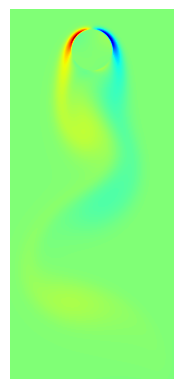

In [339]:
plt.imshow(X[:, 20].reshape(449,199), cmap='jet')
plt.axis('off')
plt.show()

In [340]:


# Define the downsampling factor
downsample_factor = 1 / 20

# Original dimensions
original_height = 449
original_width = 199

# New dimensions
new_height = int(round(original_height * downsample_factor,0))
new_width = int(round(original_width * downsample_factor,0))

# Number of snapshots
num_snapshots = X.shape[1]

# Initialize the downsampled data matrix
downsampled_data = np.zeros((new_height * new_width, num_snapshots))

# Downsample each snapshot
for i in range(num_snapshots):
    # Reshape the column into the original 2D field
    snapshot = X[:, i].reshape(original_height, original_width)
    # Downsample using zoom
    downsampled_snapshot = zoom(snapshot, (downsample_factor, downsample_factor))
    # Flatten and store
    downsampled_data[:, i] = downsampled_snapshot.flatten()



downsampled_data = normalize(downsampled_data, axis=0)
print('New height:', new_height)
print('New width:', new_width)
print('Downsampled data shape:', downsampled_data.shape)

New height: 22
New width: 10
Downsampled data shape: (220, 151)


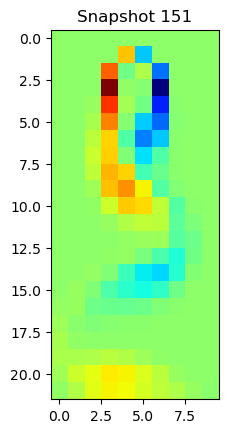

In [341]:


fig, ax = plt.subplots()

# Reshape downsampled data for plotting
downsampled_snapshots = downsampled_data.reshape(new_height, new_width, num_snapshots)

def animate(i):
    ax.clear()
    im = ax.imshow(downsampled_snapshots[:, :, i], cmap='jet', origin='upper')
    ax.set_title(f'Snapshot {i+1}')
    return [im]

# Create the animation
ani = FuncAnimation(fig, animate, frames=range(num_snapshots), interval=100, blit=True)

# Save the animation as a gif
ani.save('downscaled_flow_field_animation.gif', writer='pillow', fps=10)

plt.show()

In [342]:
snapshot_idx = 65

# Get the full-resolution snapshot
original_snapshot = normalize(X[:, snapshot_idx].reshape(original_height, original_width), axis=0)
original_snapshot = X[:, snapshot_idx].reshape(original_height, original_width)

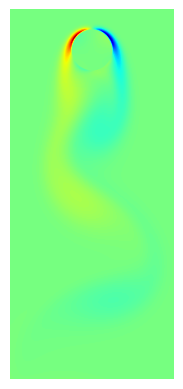

In [343]:
plt.imshow(original_snapshot, cmap='jet')
plt.axis('off')
plt.show()

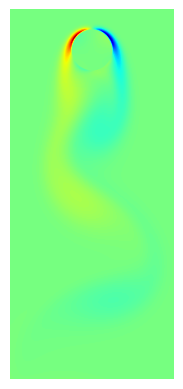

In [364]:
original_snapshot_with_noise = original_snapshot + 0.0000 * np.random.randn(original_height, original_width)

plt.imshow(original_snapshot_with_noise, cmap='jet')
plt.axis('off')
plt.show()

In [365]:
downsampled_original_snapshot_with_noise = zoom(original_snapshot_with_noise, (downsample_factor, downsample_factor))
downsampled_data_snapshot_with_noise = downsampled_original_snapshot_with_noise.flatten()

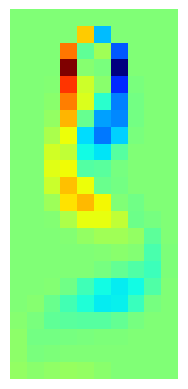

In [366]:
plt.imshow(downsampled_original_snapshot_with_noise, cmap='jet')
plt.axis('off')
plt.show()

In [367]:
from scipy.optimize import minimize
y1 = np.copy(downsampled_data_snapshot_with_noise)

def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  np.linalg.norm(downsampled_data @ x - y1,2)-1e-15})
# Have the norm 2 solution as the initial guess
x0 = np.linalg.pinv(downsampled_data) @ y1
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr, options = {'maxiter': 1000, 'disp': True})
res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.04191379283644469
            Iterations: 1
            Function evaluations: 161
            Gradient evaluations: 1


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.04191379283644469
       x: [ 5.163e-11  1.070e-11 ...  2.691e-11  1.885e-12]
     nit: 1
     jac: [ 1.000e+00  1.000e+00 ...  1.000e+00  9.998e-01]
    nfev: 161
    njev: 1

In [368]:
print('Chosen snapshot index:', snapshot_idx) 
print('L1 norm:', np.argmax(res.x))

Chosen snapshot index: 65
L1 norm: 65


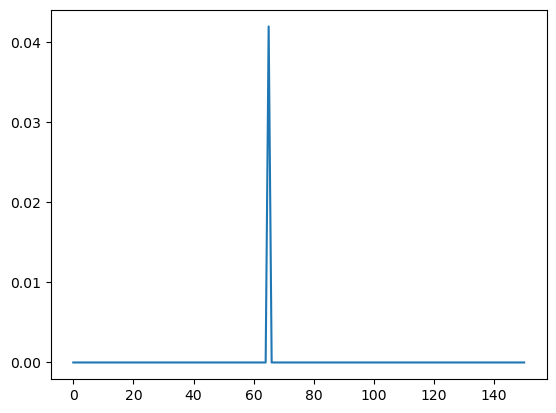

In [369]:
plt.plot(res.x)
plt.show()


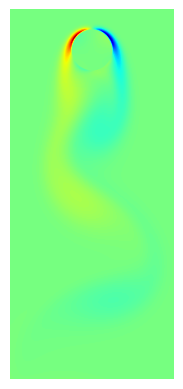

In [370]:
plt.imshow((X @ res.x).reshape(original_height, original_width), cmap='jet')
plt.axis('off')
plt.show()

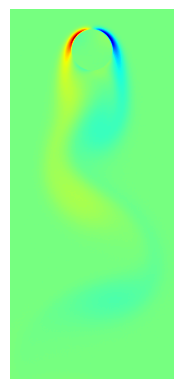

In [371]:
original_snapshot_with_noise = original_snapshot + 0.0001 * np.random.randn(original_height, original_width)

plt.imshow(original_snapshot_with_noise, cmap='jet')
plt.axis('off')
plt.show()

In [372]:
downsampled_original_snapshot_with_noise = zoom(original_snapshot_with_noise, (downsample_factor, downsample_factor))
downsampled_data_snapshot_with_noise = downsampled_original_snapshot_with_noise.flatten()

In [373]:
from scipy.optimize import minimize
y1 = np.copy(downsampled_data_snapshot_with_noise)

def L1_norm(x):
    return np.linalg.norm(x,ord=1)

constr = ({'type': 'ineq', 'fun': lambda x:  np.linalg.norm(downsampled_data @ x - y1,2)-1e-15})
# Have the norm 2 solution as the initial guess
x0 = np.linalg.pinv(downsampled_data) @ y1
res = minimize(L1_norm, x0, method='SLSQP',constraints=constr, options = {'maxiter': 1000, 'disp': True})
res

Optimization terminated successfully    (Exit mode 0)
            Current function value: 5.6749542571578765e-05
            Iterations: 612
            Function evaluations: 94301
            Gradient evaluations: 612


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 5.6749542571578765e-05
       x: [-2.628e-07  9.808e-07 ...  1.005e-07  4.552e-08]
     nit: 612
     jac: [-1.000e+00  1.000e+00 ...  1.000e+00  1.000e+00]
    nfev: 94301
    njev: 612

In [374]:
print('Chosen snapshot index:', snapshot_idx) 
print('L1 norm:', np.argmax(res.x))

Chosen snapshot index: 65
L1 norm: 16


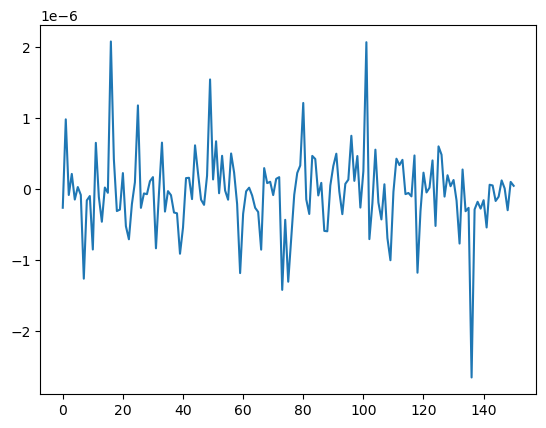

In [375]:
plt.plot(res.x)
plt.show()

It works very well for no noise but just a little bit of noise and it breaks.

# Exercise 3-7

This exercise will explore RPCA from Section 3.7 for robust flow field analysis, following Scherl et al. [631].

(a) Load the cylinder flow data set. Compute the SVD as in Exercise 1-7 and
plot the movie of the flow. Also plot the singular values and first 10 singular vectors.

(b) Now, contaminate a random 10% of the entries of the data matrix with salt-and-pepper noise. The contaminated points should not be the same for each column, and the salt-and-pepper noise should be $\pm5\eta$, where $\eta$ is the standard deviation of the entire data set. Compute the SVD of the contaminated matrix and plot the movie of the flow along with the singular values and first 10 singular vectors.

(c) Clean the contaminated data set by applying RPCA and keeping the lowrank portion L. Again, compute the SVD of the decontaminated matrix L and plot the movie of the flow along with the singular values and first 10 singular vectors. Compare these with the results from the original clean and contaminated data sets.

(d) Try to clean the data by applying the Gavish–Donoho threshold to the data matrix contaminated with salt-and-pepper noise. Does this work? Explain why or why not.

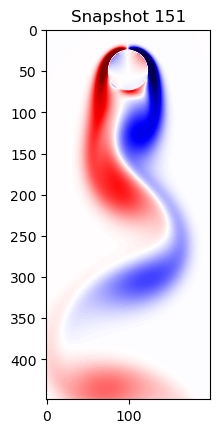

In [5]:
vortall_mat = sp.io.loadmat(os.path.join('..','DATA','VORTALL.mat'))
X = vortall_mat['VORTALL']

# Original dimensions
original_height = 449
original_width = 199
num_snapshots = X.shape[1]

fig, ax = plt.subplots()

# Reshape downsampled data for plotting
X_snapshots = X.reshape(original_height, original_width, num_snapshots)

vortmin = -5
vortmax = 5

def animate(i):
    ax.clear()
    im = ax.imshow(X_snapshots[:, :, i], cmap='seismic', origin='upper',vmin=vortmin,vmax=vortmax)
    ax.set_title(f'Snapshot {i+1}')
    return [im]

# Create the animation
ani = FuncAnimation(fig, animate, frames=range(num_snapshots), interval=100, blit=True)

# Save the animation as a gif
ani.save('flow_field_animation.gif', writer='pillow', fps=10)

plt.show()

In [6]:
U, S, VT = np.linalg.svd(X, full_matrices=False)

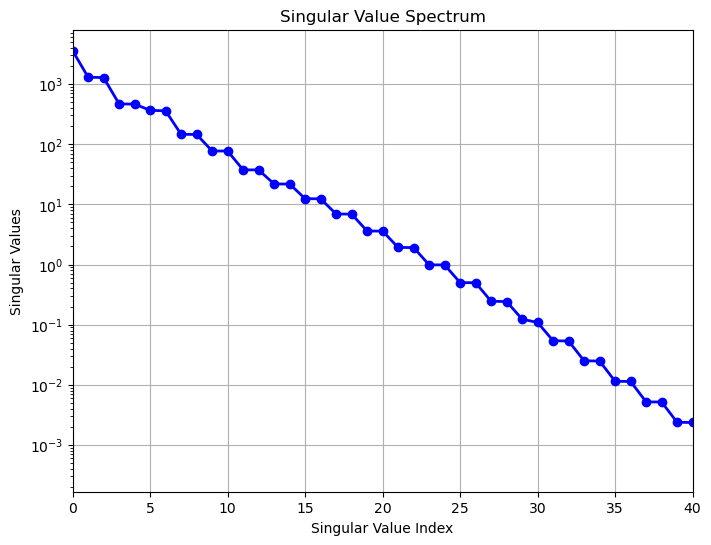

In [7]:
plt.figure(figsize=(8, 6))
plt.semilogy(S, 'bo-', linewidth=2)
plt.xlim([0, 40])
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Values')
plt.title('Singular Value Spectrum')
plt.grid(True)
plt.show()

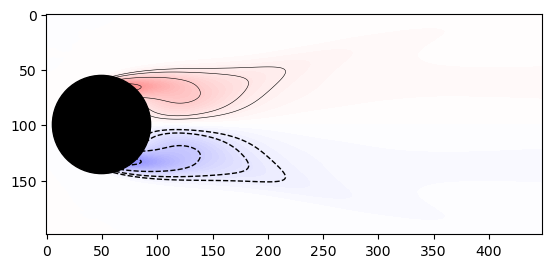

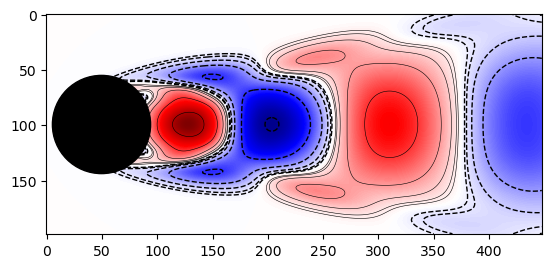

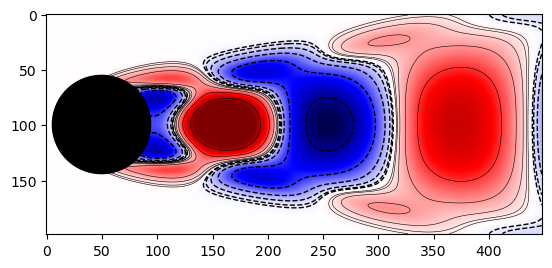

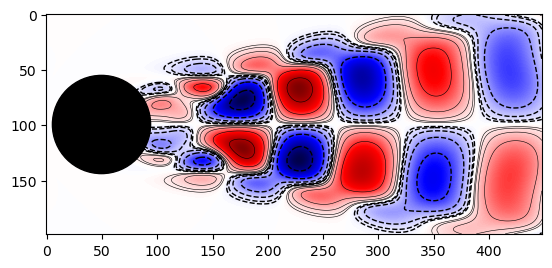

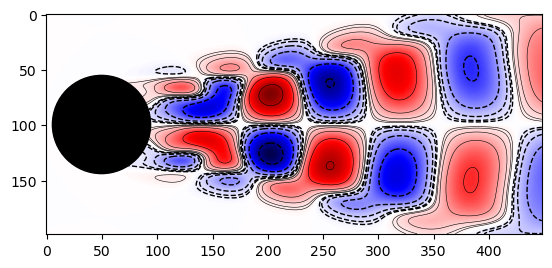

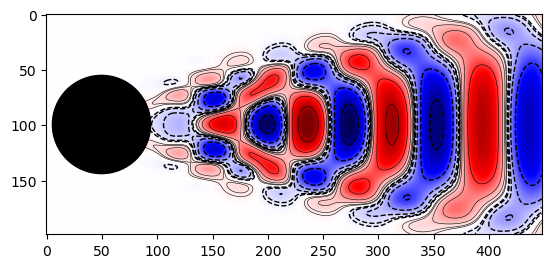

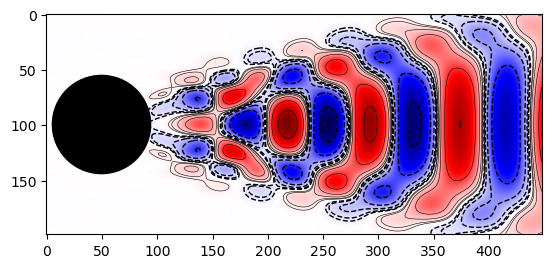

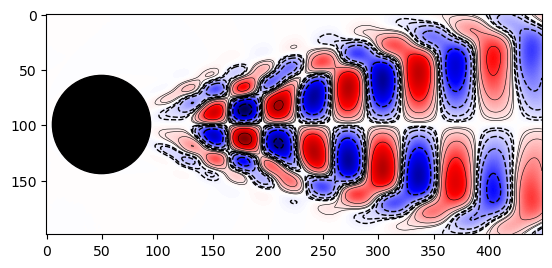

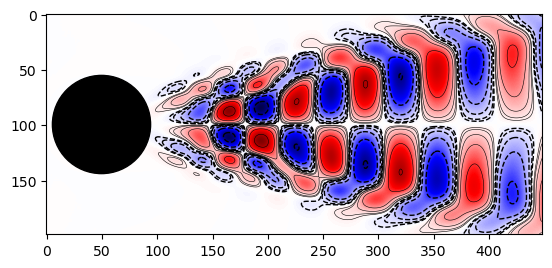

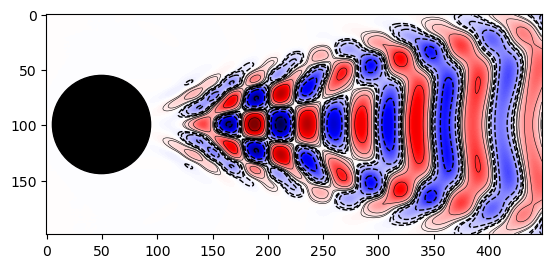

In [8]:
def plot_leading_vector(i):

    U_copy = np.copy(np.real(np.reshape(U[:,i],(original_height,original_width))))

    U_copy = U_copy.T



    minval = np.min(U_copy)
    maxval = np.max(U_copy)

    if np.abs(minval) < 5 and np.abs(maxval) < 5:
        if np.abs(minval) > np.abs(maxval):
            vortmax = maxval
            vortmin = -maxval
        else:
            vortmin = minval
            vortmax = -minval

    U_copy[U_copy > vortmax] = vortmax
    U_copy[U_copy < vortmin] = vortmin

    plt.imshow(U_copy, cmap='seismic', vmin=vortmin,vmax=vortmax)

    cvals = np.array([-4,-2,-1,-0.5,-0.25,-0.155])
    plt.contour(U_copy,cvals*vortmax/5,colors='k',linestyles='dashed',linewidths=1)
    plt.contour(U_copy,np.flip(-cvals)*vortmax/5,colors='k',linestyles='solid',linewidths=0.4)

    plt.scatter(49,99,5000,color='k') # draw cylinder

    plt.show()


for i in range(10):
    plot_leading_vector(i)

In [9]:
eta = np.std(X)
noise_intensity = 5 * eta
X_noise= X.copy()
num_elements = X_noise.size
num_noisy_elements = int(0.1 * num_elements)

random_indices = np.unravel_index(np.random.choice(num_elements, num_noisy_elements, replace=False), X_noise.shape)
noise_values = np.random.choice([-noise_intensity, noise_intensity], num_noisy_elements)
X_noise[random_indices] += noise_values

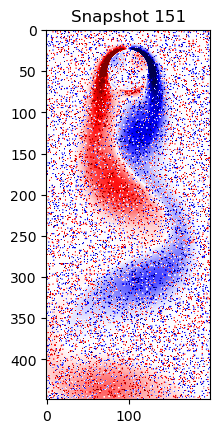

In [10]:
fig, ax = plt.subplots()

# Reshape downsampled data for plotting
X_noise_snapshots = X_noise.reshape(original_height, original_width, num_snapshots)

vortmin = -5
vortmax = 5

def animate(i):
    ax.clear()
    im = ax.imshow(X_noise_snapshots[:, :, i], cmap='seismic', origin='upper',vmin=vortmin,vmax=vortmax)
    ax.set_title(f'Snapshot {i+1}')
    return [im]

# Create the animation
ani = FuncAnimation(fig, animate, frames=range(num_snapshots), interval=100, blit=True)

# Save the animation as a gif
ani.save('flow_field_noise_animation.gif', writer='pillow', fps=10)

plt.show()

In [11]:
U, S, VT = np.linalg.svd(X_noise, full_matrices=False)

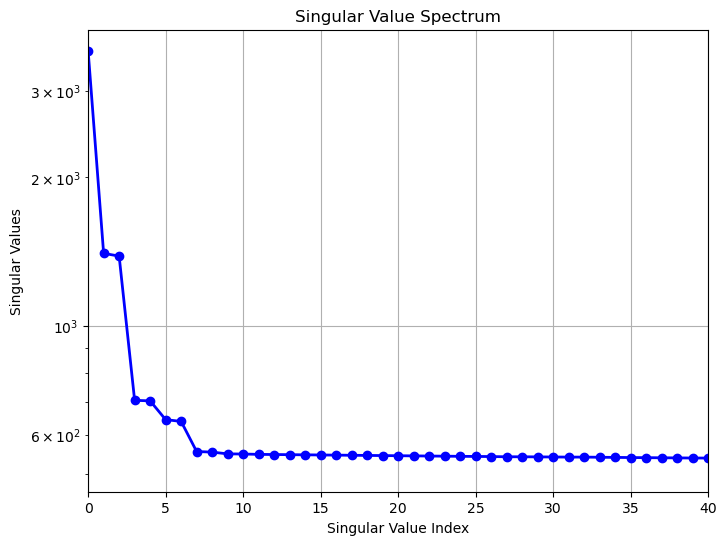

In [12]:
plt.figure(figsize=(8, 6))
plt.semilogy(S, 'bo-', linewidth=2)
plt.xlim([0, 40])
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Values')
plt.title('Singular Value Spectrum')
plt.grid(True)
plt.show()

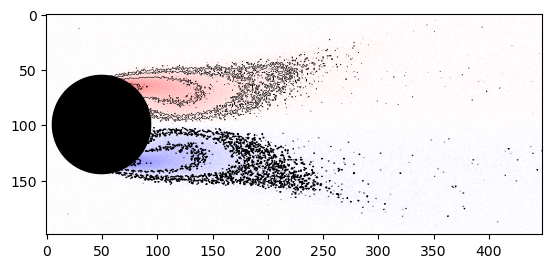

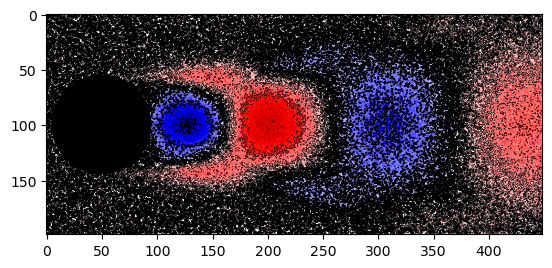

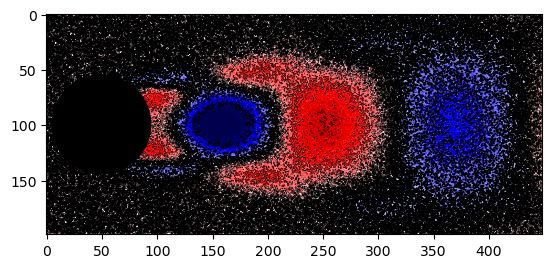

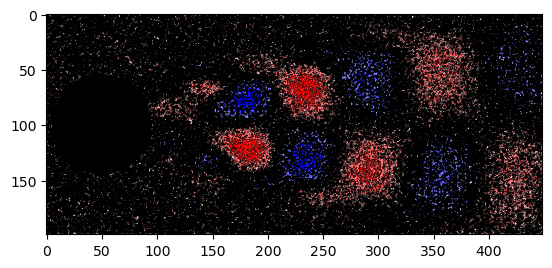

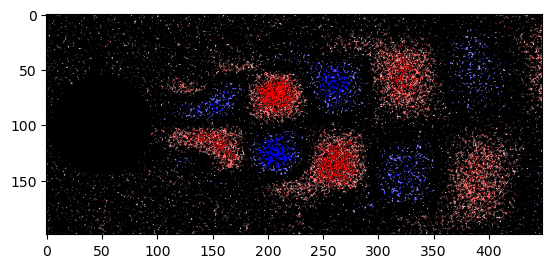

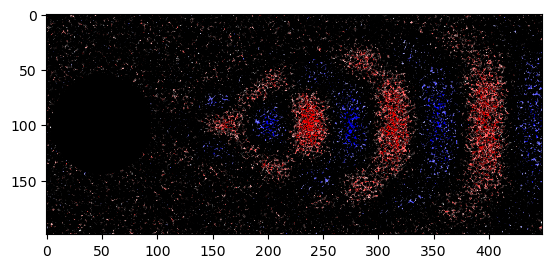

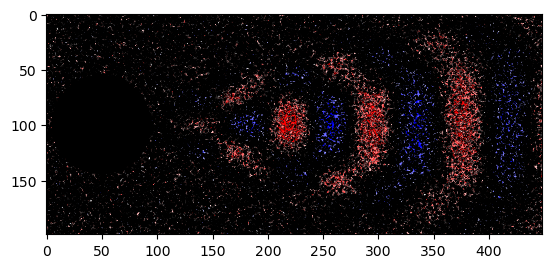

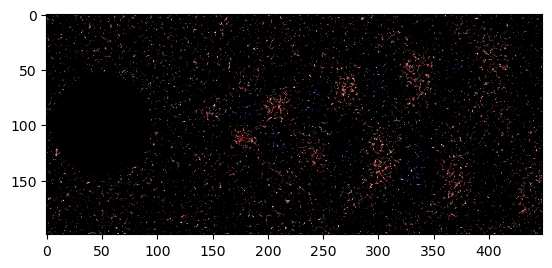

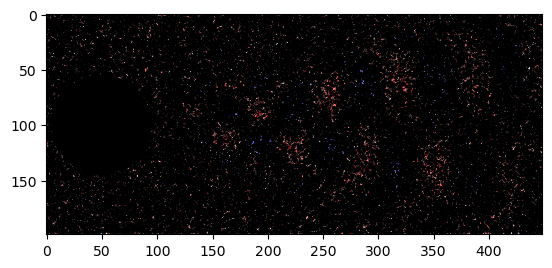

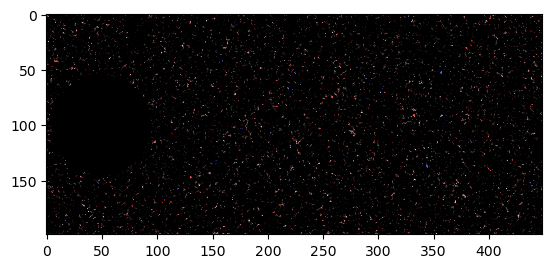

In [13]:
for i in range(10):
    plot_leading_vector(i)

In [14]:
def shrink(X,tau):
    Y = np.abs(X)-tau
    return np.sign(X) * np.maximum(Y,np.zeros_like(Y))
def SVT(X,tau):
    U,S,VT = np.linalg.svd(X,full_matrices=0)
    out = U @ np.diag(shrink(S,tau)) @ VT
    return out
def RPCA(X):
    n1,n2 = X.shape
    mu = n1*n2/(4*np.sum(np.abs(X.reshape(-1))))
    lambd = 1/np.sqrt(np.maximum(n1,n2))
    thresh = 10**(-7) * np.linalg.norm(X)
    
    S = np.zeros_like(X)
    Y = np.zeros_like(X)
    L = np.zeros_like(X)
    count = 0
    while (np.linalg.norm(X-L-S) > thresh) and (count < 500):
        if count % 10 == 0:
            print(count + '/500')
        L = SVT(X-S+(1/mu)*Y,1/mu)
        S = shrink(X-L+(1/mu)*Y,lambd/mu)
        Y = Y + mu*(X-L-S)
        count += 1
    return L,S

L, S = RPCA(X_noise)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
420
430
440
450
460
470
480
490


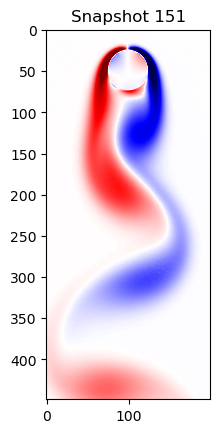

In [15]:
fig, ax = plt.subplots()

# Reshape downsampled data for plotting
L_snapshots = L.reshape(original_height, original_width, num_snapshots)

vortmin = -5
vortmax = 5

def animate(i):
    ax.clear()
    im = ax.imshow(L_snapshots[:, :, i], cmap='seismic', origin='upper',vmin=vortmin,vmax=vortmax)
    ax.set_title(f'Snapshot {i+1}')
    return [im]

# Create the animation
ani = FuncAnimation(fig, animate, frames=range(num_snapshots), interval=100, blit=True)

# Save the animation as a gif
ani.save('flow_field_L_animation.gif', writer='pillow', fps=10)

plt.show()

In [16]:
U, S, VT = np.linalg.svd(L, full_matrices=False)

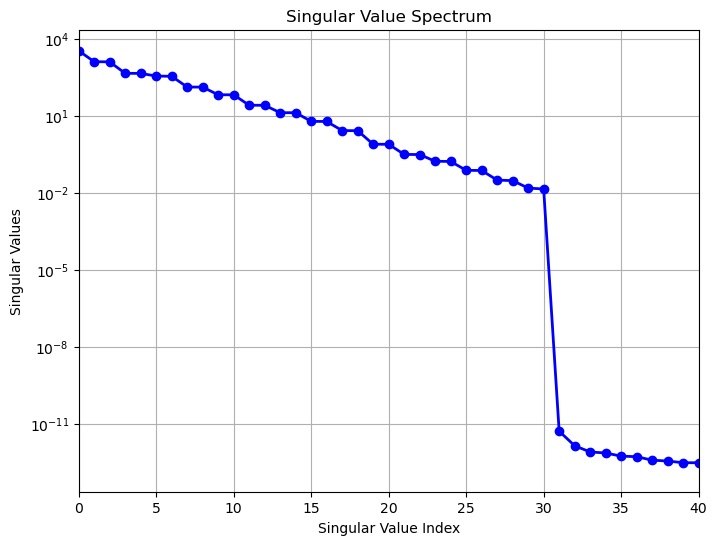

In [17]:
plt.figure(figsize=(8, 6))
plt.semilogy(S, 'bo-', linewidth=2)
plt.xlim([0, 40])
plt.xlabel('Singular Value Index')
plt.ylabel('Singular Values')
plt.title('Singular Value Spectrum')
plt.grid(True)
plt.show()

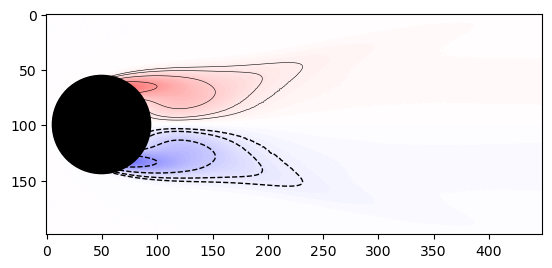

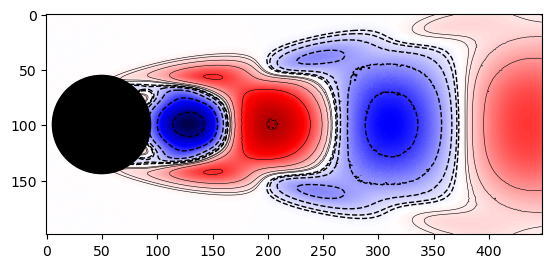

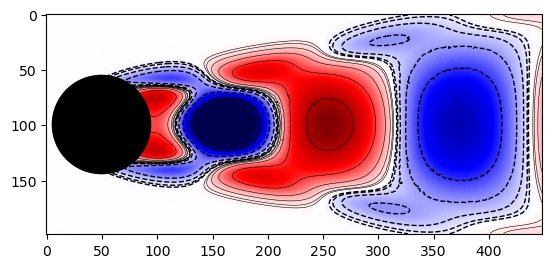

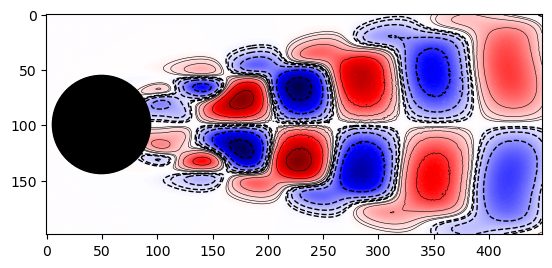

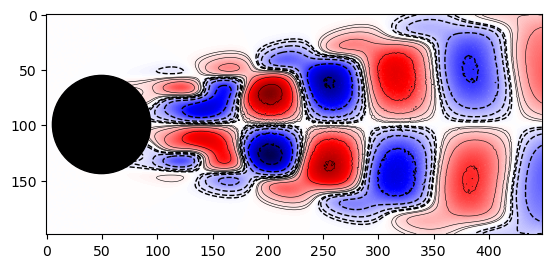

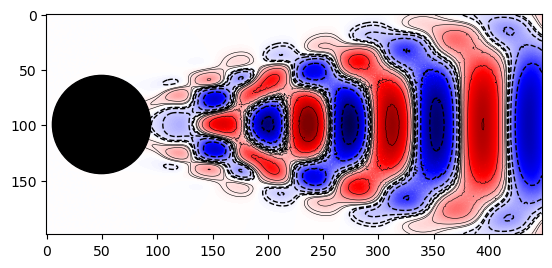

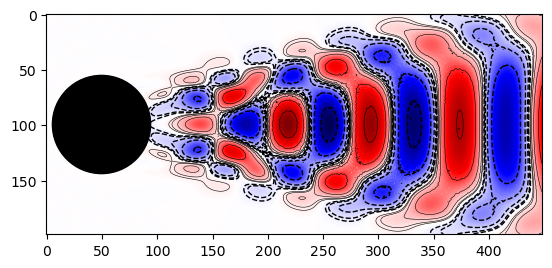

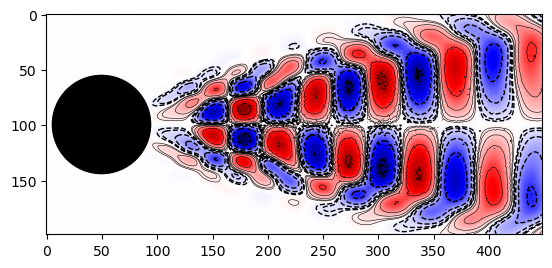

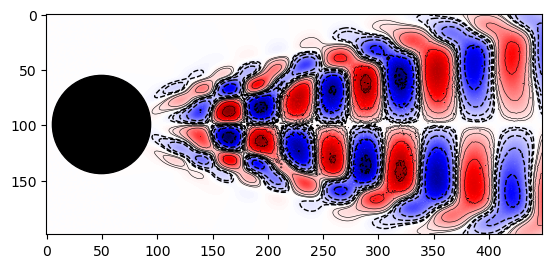

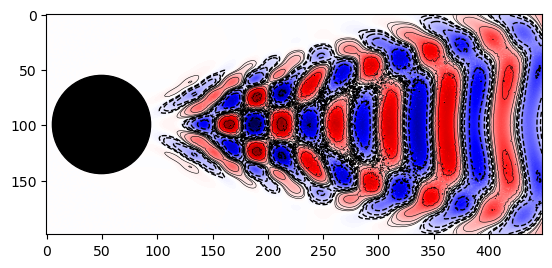

In [18]:
for i in range(10):
    plot_leading_vector(i)

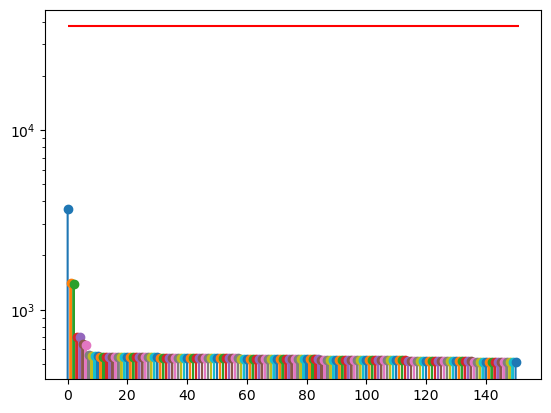

In [21]:
beta = X_noise.shape[0]/X_noise.shape[1]

sigma = noise_intensity

U, S, VT = np.linalg.svd(X_noise, full_matrices=False)

def lambda_func(beta):
    return np.sqrt(2*(beta+1) + (8*beta)/(beta+1) + (beta**2 + 14*beta + 1)/(beta+1)**(1/2))

threshold = lambda_func(beta) * np.sqrt(X.shape[0])*sigma

plt.hlines(threshold,0,len(S), colors= 'r', label = 'Closed threshold')
plt.semilogy(np.diag(S),marker='o')
plt.show()

The Gavish–Donoho threshold doesnt work at all as it would filter out everything. This is becuase this method assumes that the noise is Gaussian and not salt-and-pepper noise.

# Exercise 3-8

This exercise will explore the sparse sensor selection approach based on QR from Section 3.8.

(a) Load the Yale B faces data set. Randomly choose one person to omit from the data matrix and compute the SVD of the remaining data. Compute the QR sensor locations for $p = 100$ using the first $r = 100$ modes of this SVD basis $\tilde{U}$ . Use these sensor locations to reconstruct the images of the person that was left out of the matrix for the SVD. Compare the reconstruction error using these QR sensor locations with reconstruction using $p = 100$ randomly chosen sensors, as in Fig. 3.22.

(b) Now, repeat this experiment 36 times, each time omitting a different person from the data before computing the SVD, and use the sensor locations to reconstruct the images of the omitted person. This will provide enough reconstruction errors on which to perform statistics. For each experiment, also compute the reconstruction error using 36 different configurations of $p = 100$ random sensors. Plot the histograms of the error for the QR and random sensors, and discuss.

(c) Finally, repeat the above experiments for different sensor number $p = 10$ through $p = 200$ in increments of 10. Plot the error distributions versus
p for QR and random sensor configurations. Because each value of p corresponds to many reconstruction errors, it would be best to plot this as a box-and-whisker plot or as a violin plot.

In [2]:
mat_contents = sp.io.loadmat(os.path.join("..","DATA","allFaces.mat"))
faces = mat_contents["faces"]
m_face = int(mat_contents["m"])
n_face = int(mat_contents["n"])

X = faces

## a)

In [46]:
mat_contents

{'__header__': b'MATLAB 5.0 MAT-file, Platform: MACI64, Created on: Thu Sep  4 19:53:55 2014',
 '__version__': '1.0',
 '__globals__': [],
 'faces': array([[80, 94, 59, ...,  3,  4,  4],
        [81, 87, 67, ...,  4,  4,  3],
        [80, 88, 66, ...,  2,  4,  4],
        ...,
        [14,  7,  6, ...,  0,  1,  1],
        [14,  9,  6, ...,  1,  1,  0],
        [11,  8,  7, ...,  1,  1,  2]], dtype=uint8),
 'n': array([[192]], dtype=uint8),
 'm': array([[168]], dtype=uint8),
 'sub': array([[(array([[39]], dtype=uint8), array([[70, 84, 88, ...,  3,  4,  4],
                [74, 83, 95, ...,  4,  4,  3],
                [69, 82, 97, ...,  2,  4,  4],
                ...,
                [ 1,  2,  3, ...,  0,  1,  1],
                [ 1,  3,  3, ...,  1,  1,  0],
                [ 2,  2,  3, ...,  1,  1,  2]], dtype=uint8), array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
                 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
          

In [41]:
X.shape

(32256, 2410)

In [15]:
index_of_omitted_person = 14
r = 100
p = 100
n = X.shape[0]

X_omit = np.delete(X, index_of_omitted_person, axis=1)  # Exclude one person
U, S, Vt = np.linalg.svd(X_omit, full_matrices=False)
U_r = U[:, :r]  # Use the first r modes, with r=100

In [42]:
X_omit.shape

(32256, 2409)

In [20]:
Q, R, pivot = qr(U_r.T, pivoting=True)

In [21]:
C = np.zeros((p, n))
for j in range(p):
    C[j, pivot[j]] = 1

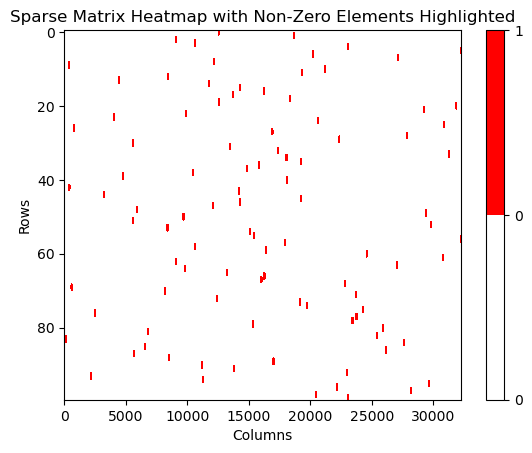

In [26]:
from matplotlib import colors
cmap = colors.ListedColormap(['white', 'red'])

# Use boundary norm to clearly distinguish between 0 and non-zero values
bounds = [0, 1e-10, 1]  # 0 is white, anything non-zero is red
norm = colors.BoundaryNorm(bounds, cmap.N)

# Plot the sparse matrix heatmap
plt.imshow(C, cmap=cmap, norm=norm, aspect='auto')
plt.colorbar()  # Add a color bar to show the scale
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.grid(False)  # Disable the grid to improve clarity
plt.show()

In [70]:
pivot[:r].shape

(100,)

In [72]:
pivot.shape

(32256,)

In [63]:
Theta = C @ U_r
y_full = X[:, index_of_omitted_person]
y = y_full[pivot[:r]]
a = np.linalg.pinv(Theta) @ y
reconstructed = U_r @ a

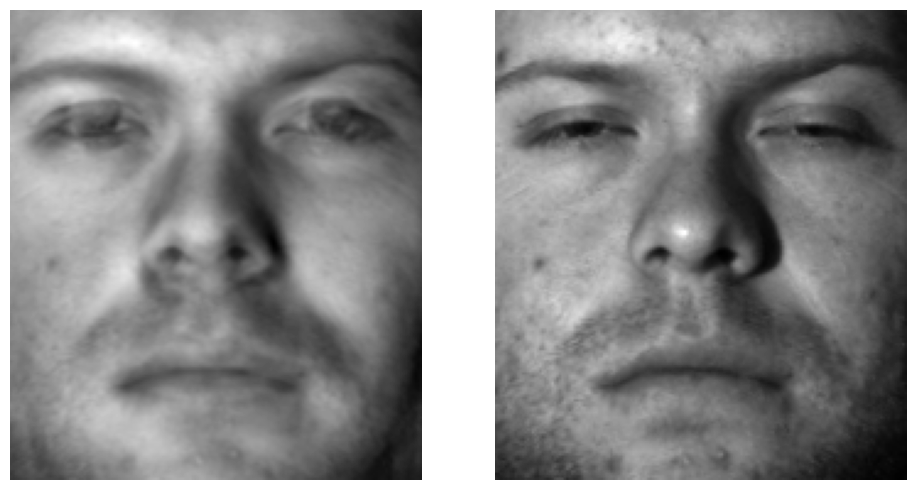

In [66]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Reconstruct the omitted face
reconstructed_face = np.reshape(reconstructed,(m_face,n_face)).T
img_avg1 = ax1.imshow(reconstructed_face, cmap='gray')
ax1.axis('off')

# Original omitted face
img_avg2 = ax2.imshow(np.reshape(y_full,(m_face,n_face)).T, cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [76]:
error = np.linalg.norm(y_full -reconstructed) / np.linalg.norm(y_full)
error

0.1399936617583603

In [73]:
random_sensor_indices = np.random.choice(X.shape[0] , size=p, replace=False)
Theta_random = U_r[random_sensor_indices, :] 
y_random = y_full[random_sensor_indices]
a_random = np.linalg.pinv(Theta_random) @ y_random
reconstructed_random = U_r @ a_random

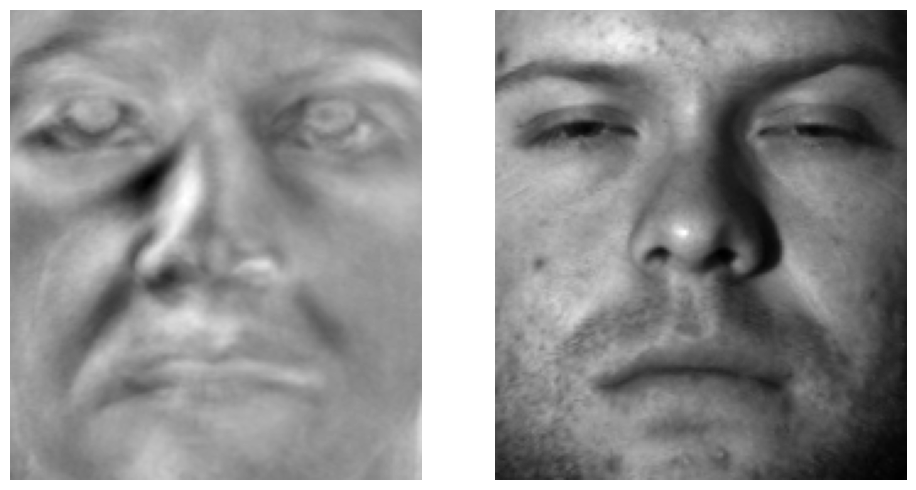

In [75]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Reconstruct the omitted face
reconstructed_random_face = np.reshape(reconstructed_random,(m_face,n_face)).T
img_avg1 = ax1.imshow(reconstructed_random_face, cmap='gray')
ax1.axis('off')

# Original omitted face
img_avg2 = ax2.imshow(np.reshape(y_full,(m_face,n_face)).T, cmap='gray')
ax2.axis('off')
plt.tight_layout()
plt.show()

In [78]:
error_random = np.linalg.norm(y_full - reconstructed_random) / np.linalg.norm(y_full)
error_random

1.7284672975819588

In [92]:
idx = 0
i = mat_contents['nfaces'][0][0]

start_idx = idx
end_idx = idx + i
idx = end_idx
errors_QR_all = []
errors_random_all = []

X_omit = np.delete(X, np.arange(start_idx, end_idx), axis=1)
print(X.shape)
print(X_omit.shape)
print(X.shape[1] - X_omit.shape[1])

(32256, 2410)
(32256, 2346)
64


## b)

In [3]:
def experiment(r, p, nr_random_trials=len(mat_contents['nfaces'][0])):
    idx = 0
    temp_idx = 1
    for i in mat_contents['nfaces'][0]:
        print('Person:', temp_idx, '/', len(mat_contents['nfaces'][0]))
        temp_idx += 1
        start_idx = idx
        end_idx = idx + i - 1
        idx = end_idx
        errors_QR_all = []
        errors_random_all = []
    
        X_omit = np.delete(X, np.arange(start_idx, end_idx), axis=1)

        U, _, _ = np.linalg.svd(X_omit, full_matrices=False)
        U_r = U[:, :r]
        Q, R, pivot = qr(U_r.T, pivoting=True)
        C = np.zeros((p, X.shape[0]))
        for j in range(p):
            C[j, pivot[j]] = 1
        Theta = C @ U_r
        y_full = X[:, start_idx:end_idx]
        y = y_full[pivot[:r]]
        for img_idx in range(y_full.shape[1]):
            y_image = y_full[:, img_idx]  # Single image vector

            # Extract sensor readings using QR-selected sensor locations
            y_QR = y_image[pivot[:p]]
            # Solve for the coefficients a using QR sensor locations
            a_QR = np.linalg.pinv(Theta) @ y_QR

            # Reconstruct the image using the SVD basis
            reconstructed_QR = U_r @ a_QR

            # Compute reconstruction error for this image (QR-based)
            error_QR = np.linalg.norm(y_image - reconstructed_QR) / np.linalg.norm(y_image)
            errors_QR_all.append(error_QR)

            # Repeat the same process for random sensor selection
            for _ in range(nr_random_trials):
                random_sensor_indices = np.random.choice(X.shape[0], size=p, replace=False)
                Theta_random = U_r[random_sensor_indices, :]
                y_random = y_image[random_sensor_indices]
                a_random = np.linalg.pinv(Theta_random) @ y_random
                reconstructed_random = U_r @ a_random
                error_random = np.linalg.norm(y_image - reconstructed_random) / np.linalg.norm(y_image)
                errors_random_all.append(error_random)

    return errors_QR_all, errors_random_all

In [105]:
errors_QR_all, errors_random_all = experiment(100, 100)

Person: 1 / 38
Person: 2 / 38
Person: 3 / 38
Person: 4 / 38
Person: 5 / 38
Person: 6 / 38
Person: 7 / 38
Person: 8 / 38
Person: 9 / 38
Person: 10 / 38
Person: 11 / 38
Person: 12 / 38
Person: 13 / 38
Person: 14 / 38
Person: 15 / 38
Person: 16 / 38
Person: 17 / 38
Person: 18 / 38
Person: 19 / 38
Person: 20 / 38
Person: 21 / 38
Person: 22 / 38
Person: 23 / 38
Person: 24 / 38
Person: 25 / 38
Person: 26 / 38
Person: 27 / 38
Person: 28 / 38
Person: 29 / 38
Person: 30 / 38
Person: 31 / 38
Person: 32 / 38
Person: 33 / 38
Person: 34 / 38
Person: 35 / 38
Person: 36 / 38
Person: 37 / 38
Person: 38 / 38


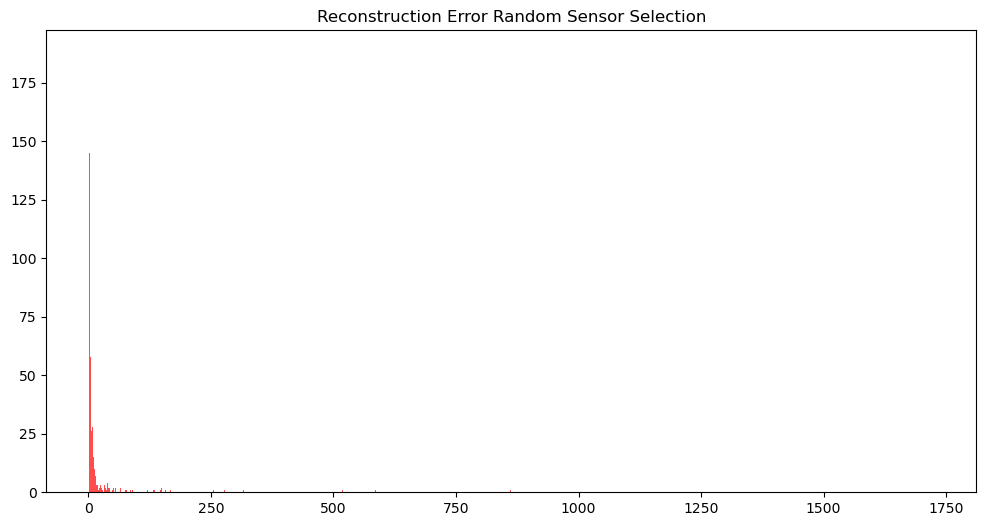

In [125]:
plt.figure(figsize=(12, 6))
plt.hist(errors_random_all, bins=5000, alpha=0.7, label='Random', color='red')
plt.title('Reconstruction Error Random Sensor Selection')
plt.show()

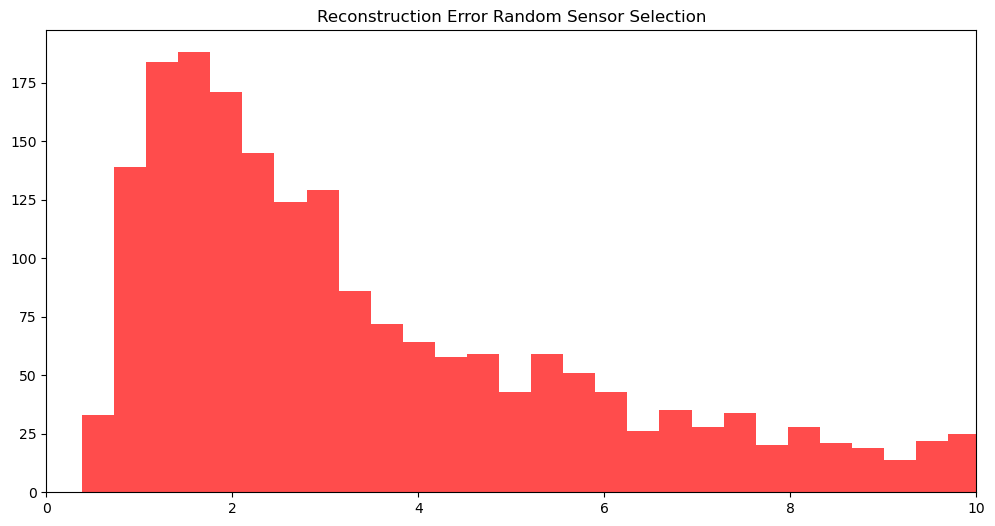

In [124]:
plt.figure(figsize=(12, 6))
bins = 30
plt.hist(errors_random_all, bins=5000, alpha=0.7, label='Random', color='red')
plt.title('Reconstruction Error Random Sensor Selection')
plt.xlim([0, 10])
plt.show()

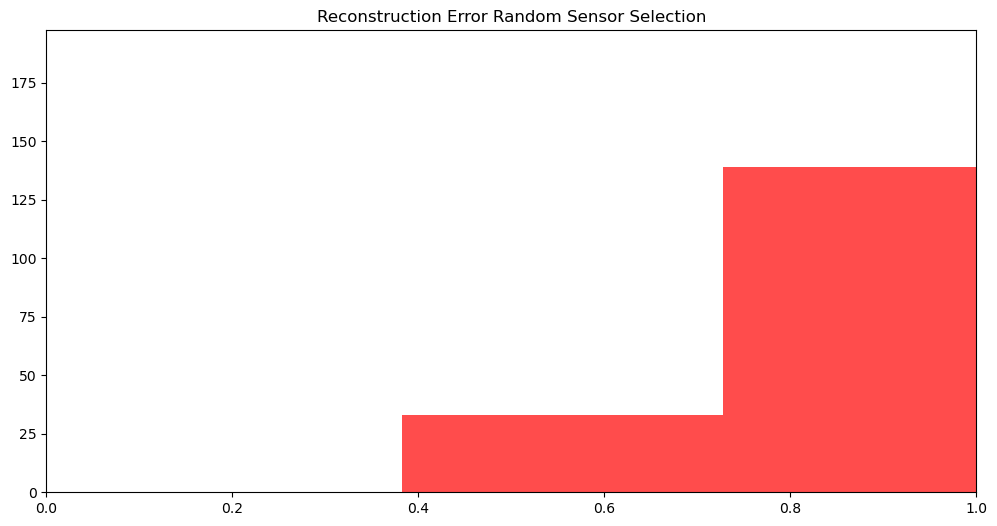

In [128]:
plt.figure(figsize=(12, 6))
bins = 30
plt.hist(errors_random_all, bins=5000, alpha=0.7, label='Random', color='red')
plt.title('Reconstruction Error Random Sensor Selection')
plt.xlim([0, 1])
plt.show()

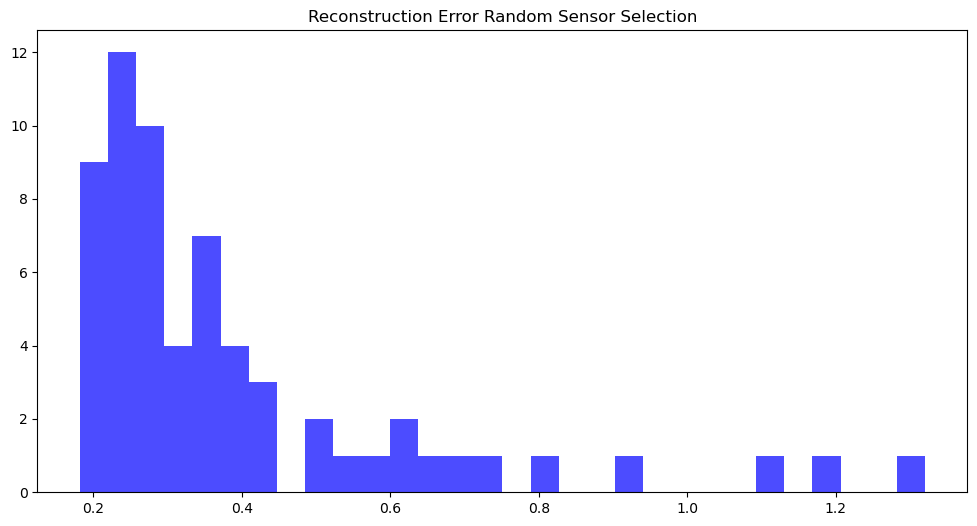

In [126]:
plt.figure(figsize=(12, 6))
plt.hist(errors_QR_all, bins=30, alpha=0.7, label='Random', color='blue')
plt.title('Reconstruction Error Random Sensor Selection')
plt.show()

The QR sensor locations provide a more consistent and lower reconstruction error compared to randomly chosen sensors. The best random sensor locations have a similar reconstruction error to an "ok" QR sensor location, but the worst random sensor locations have a much higher reconstruction error.
The random sensor locations have a wider range of reconstruction errors but in general it performs quite well considering that the sensors are chosen randomly.

## c)

In [4]:
# This takes a very long time to run

# p_values = np.arange(10, 201, 10)
# all_errors_QR = []
# all_errors_random = []

# for p in p_values:
#     print(f'Running experiment for p = {p}')
#     errors_QR, errors_random = experiment(r=100, p=p)
#     all_errors_QR.append(errors_QR)
#     all_errors_random.append(errors_random)

Running experiment for p = 10
Person: 1 / 38
Person: 2 / 38
Person: 3 / 38
Person: 4 / 38
Person: 5 / 38
Person: 6 / 38
Person: 7 / 38
Person: 8 / 38
Person: 9 / 38
Person: 10 / 38
Person: 11 / 38
Person: 12 / 38
Person: 13 / 38
Person: 14 / 38
Person: 15 / 38
Person: 16 / 38
Person: 17 / 38
Person: 18 / 38
Person: 19 / 38
Person: 20 / 38
Person: 21 / 38
Person: 22 / 38
Person: 23 / 38
Person: 24 / 38
Person: 25 / 38
Person: 26 / 38
Person: 27 / 38
Person: 28 / 38
Person: 29 / 38
Person: 30 / 38
Person: 31 / 38
Person: 32 / 38
Person: 33 / 38
Person: 34 / 38
Person: 35 / 38
Person: 36 / 38
Person: 37 / 38
Person: 38 / 38
Running experiment for p = 20
Person: 1 / 38
Person: 2 / 38
Person: 3 / 38
Person: 4 / 38
Person: 5 / 38
Person: 6 / 38
Person: 7 / 38
Person: 8 / 38
Person: 9 / 38
Person: 10 / 38
Person: 11 / 38
Person: 12 / 38
Person: 13 / 38
Person: 14 / 38
Person: 15 / 38
Person: 16 / 38
Person: 17 / 38
Person: 18 / 38
Person: 19 / 38
Person: 20 / 38
Person: 21 / 38
Person: 22 / 3

In [5]:
# import csv
# with open('errors_QR_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(all_errors_QR)

# with open('errors_random_all.csv', 'w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerows(all_errors_random)

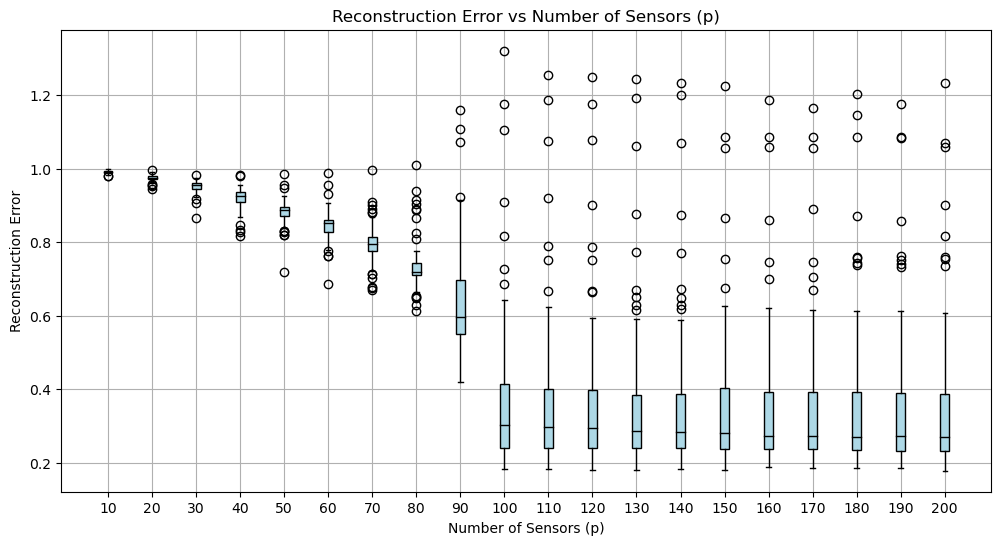

In [10]:
plt.figure(figsize=(12, 6))

# Boxplot for QR-based sensor selection
plt.boxplot(all_errors_QR, positions=np.array(p_values), widths=2, patch_artist=True, 
            boxprops=dict(facecolor="lightblue"), medianprops=dict(color="black"))

plt.xticks(p_values, p_values)
plt.xlabel('Number of Sensors (p)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Sensors (p)')
plt.grid(True)
plt.show()

The reconstruction error decreases as the number of sensors p increases for QR. At p = 100 which is the number of modes in the SVD basis, the reconstruction error is quite low and after that the error remains on a constant low level.

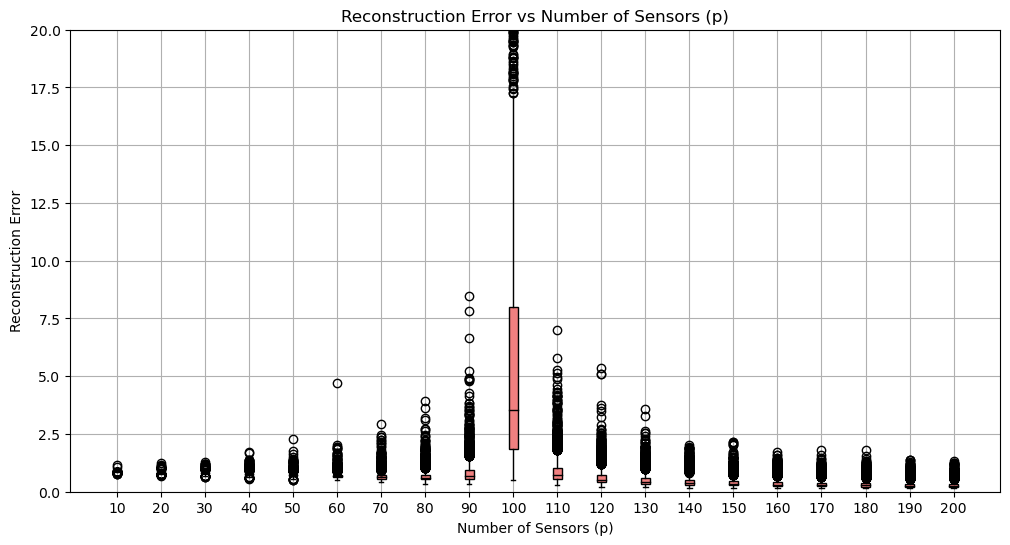

In [14]:
plt.figure(figsize=(12, 6))

# Boxplot for QR-based sensor selection
plt.boxplot(all_errors_random, positions=np.array(p_values), widths=2, patch_artist=True,
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

plt.ylim([0, 20])
plt.xticks(p_values, p_values)
plt.xlabel('Number of Sensors (p)')
plt.ylabel('Reconstruction Error')
plt.title('Reconstruction Error vs Number of Sensors (p)')
plt.grid(True)
plt.show()

The reconstruction error for random sensors is in general high but when the number of sensors is the same as the number of modes in the SVD basis the error becomes very much larger compared to the resot of the setups. The reason for this I do not know, as I would expect the curve to look similar but larger than the QR curve.

# Exercise 3-9

In the exercise above, for $p=100$, compare the reconstruction results using the $p=100$ QR sensors to reconstruct in the first $r=100$ modes, versus using the same sensors to reconstruct in the first $r=90$ SVD modes. Is one more accurate than the other? Compare the condition number of the $100\times 100$ and $100\times 90$ matrices obtained by sampling the $p$ rows of the $r=100$ and $r=90$ columns of $\tilde{U}$ from the SVD.

In [15]:
def experiment_compare_condition(r_100, r_90, p, nr_random_trials=len(mat_contents['nfaces'][0])):
    idx = 0
    temp_idx = 1
    errors_QR_100 = []
    errors_QR_90 = []
    condition_numbers_100 = []
    condition_numbers_90 = []

    for i in mat_contents['nfaces'][0]:
        print('Person:', temp_idx, '/', len(mat_contents['nfaces'][0]))
        temp_idx += 1
        start_idx = idx
        end_idx = idx + i - 1
        idx = end_idx
    
        X_omit = np.delete(X, np.arange(start_idx, end_idx), axis=1)

        # Perform SVD on the omitted data
        U, _, _ = np.linalg.svd(X_omit, full_matrices=False)
        
        # Truncate SVD basis for r=100 and r=90 modes
        U_100 = U[:, :r_100]
        U_90 = U[:, :r_90]
        
        # QR pivoting on U_100 and U_90
        Q_100, R_100, pivot_100 = qr(U_100.T, pivoting=True)
        Q_90, R_90, pivot_90 = qr(U_90.T, pivoting=True)

        # Construct C matrices for both cases
        C_100 = np.zeros((p, X.shape[0]))
        C_90 = np.zeros((p, X.shape[0]))
        
        for j in range(p):
            C_100[j, pivot_100[j]] = 1
            C_90[j, pivot_90[j]] = 1
        
        # Theta matrices for both cases
        Theta_100 = C_100 @ U_100
        Theta_90 = C_90 @ U_90
        
        # Compute condition numbers
        cond_100 = np.linalg.cond(Theta_100)
        cond_90 = np.linalg.cond(Theta_90)
        condition_numbers_100.append(cond_100)
        condition_numbers_90.append(cond_90)

        y_full = X[:, start_idx:end_idx]
        
        for img_idx in range(y_full.shape[1]):
            y_image = y_full[:, img_idx]
            
            # QR-based reconstruction with r=100 modes
            y_QR_100 = y_image[pivot_100[:p]]
            a_QR_100 = np.linalg.pinv(Theta_100) @ y_QR_100
            reconstructed_QR_100 = U_100 @ a_QR_100
            error_QR_100 = np.linalg.norm(y_image - reconstructed_QR_100) / np.linalg.norm(y_image)
            errors_QR_100.append(error_QR_100)
            
            # QR-based reconstruction with r=90 modes
            y_QR_90 = y_image[pivot_90[:p]]
            a_QR_90 = np.linalg.pinv(Theta_90) @ y_QR_90
            reconstructed_QR_90 = U_90 @ a_QR_90
            error_QR_90 = np.linalg.norm(y_image - reconstructed_QR_90) / np.linalg.norm(y_image)
            errors_QR_90.append(error_QR_90)

    return errors_QR_100, errors_QR_90, condition_numbers_100, condition_numbers_90

In [17]:
errors_QR_100, errors_QR_90, cond_100, cond_90 = experiment_compare_condition(100, 90, 100)

Person: 1 / 38
Person: 2 / 38
Person: 3 / 38
Person: 4 / 38
Person: 5 / 38
Person: 6 / 38
Person: 7 / 38
Person: 8 / 38
Person: 9 / 38
Person: 10 / 38
Person: 11 / 38
Person: 12 / 38
Person: 13 / 38
Person: 14 / 38
Person: 15 / 38
Person: 16 / 38
Person: 17 / 38
Person: 18 / 38
Person: 19 / 38
Person: 20 / 38
Person: 21 / 38
Person: 22 / 38
Person: 23 / 38
Person: 24 / 38
Person: 25 / 38
Person: 26 / 38
Person: 27 / 38
Person: 28 / 38
Person: 29 / 38
Person: 30 / 38
Person: 31 / 38
Person: 32 / 38
Person: 33 / 38
Person: 34 / 38
Person: 35 / 38
Person: 36 / 38
Person: 37 / 38
Person: 38 / 38


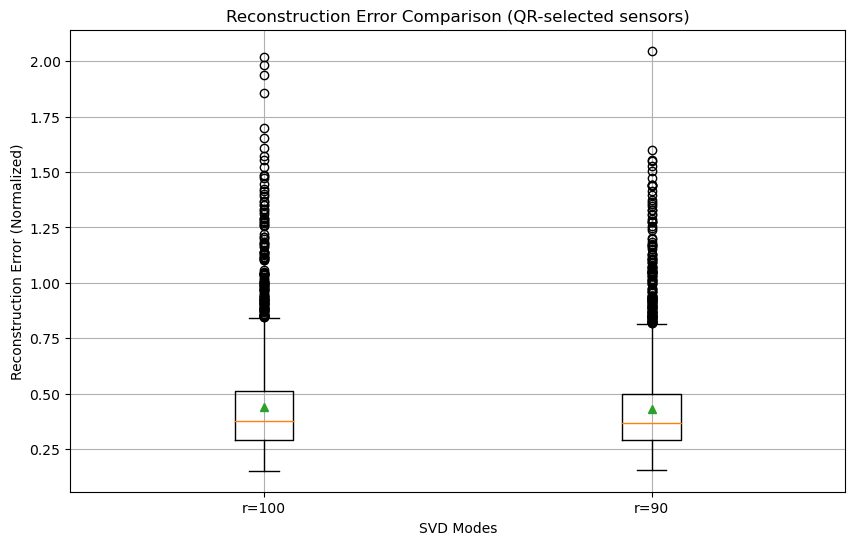

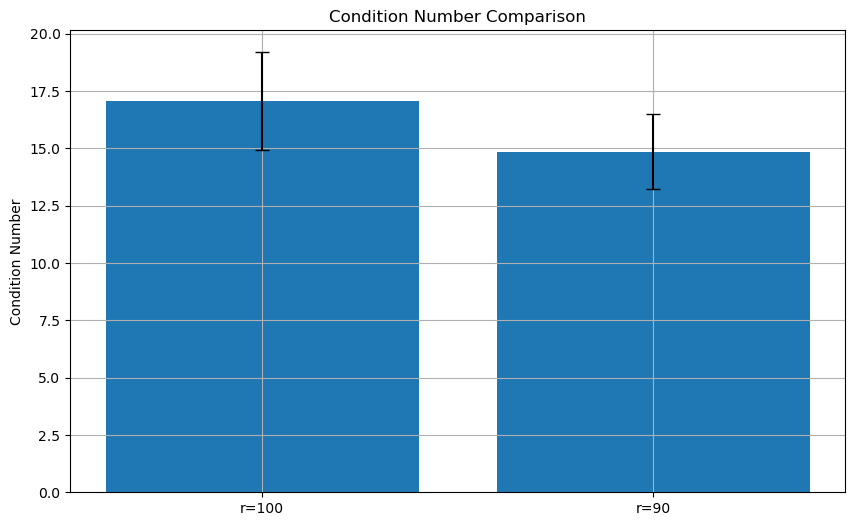

Reconstruction Error Statistics:
r=100: Mean = 0.4407, Std Dev = 0.2254
r=90: Mean = 0.4324, Std Dev = 0.2146

Condition Number Statistics:
r=100: Mean = 17.07, Std Dev = 2.13
r=90: Mean = 14.87, Std Dev = 1.63


In [18]:
# Calculate the mean and standard deviation of reconstruction errors
mean_error_100 = np.mean(errors_QR_100)
std_error_100 = np.std(errors_QR_100)
mean_error_90 = np.mean(errors_QR_90)
std_error_90 = np.std(errors_QR_90)

# Calculate the mean and standard deviation of condition numbers
mean_cond_100 = np.mean(cond_100)
std_cond_100 = np.std(cond_100)
mean_cond_90 = np.mean(cond_90)
std_cond_90 = np.std(cond_90)

# Plot reconstruction errors (boxplot)
plt.figure(figsize=(10, 6))
plt.boxplot([errors_QR_100, errors_QR_90], labels=['r=100', 'r=90'], showmeans=True)
plt.title('Reconstruction Error Comparison (QR-selected sensors)')
plt.ylabel('Reconstruction Error (Normalized)')
plt.xlabel('SVD Modes')
plt.grid(True)
plt.show()

# Plot condition numbers (bar plot)
plt.figure(figsize=(10, 6))
plt.bar(['r=100', 'r=90'], [mean_cond_100, mean_cond_90], yerr=[std_cond_100, std_cond_90], capsize=5)
plt.title('Condition Number Comparison')
plt.ylabel('Condition Number')
plt.grid(True)
plt.show()

# Present the statistical summary
print("Reconstruction Error Statistics:")
print(f"r=100: Mean = {mean_error_100:.4f}, Std Dev = {std_error_100:.4f}")
print(f"r=90: Mean = {mean_error_90:.4f}, Std Dev = {std_error_90:.4f}")
print()
print("Condition Number Statistics:")
print(f"r=100: Mean = {mean_cond_100:.2f}, Std Dev = {std_cond_100:.2f}")
print(f"r=90: Mean = {mean_cond_90:.2f}, Std Dev = {std_cond_90:.2f}")

As expected, if you have more sensors than modes the error will be better and the condistion number will be better.